# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Beatriz Borges, Lara Orlandić, Nikolina Tomić  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

In [1]:
import cv2
import math
import cmath 
import imutils
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal
from scipy import ndimage as ndi
from scipy.stats import kurtosis, skew
from sklearn.decomposition import PCA
from skimage.morphology import disk, skeletonize
from skimage.filters import threshold_otsu, rank, sobel
from skimage.measure import label, regionprops, inertia_tensor_eigvals
from skimage import data, feature, filters, restoration, exposure, morphology, measure

PI = math.pi

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

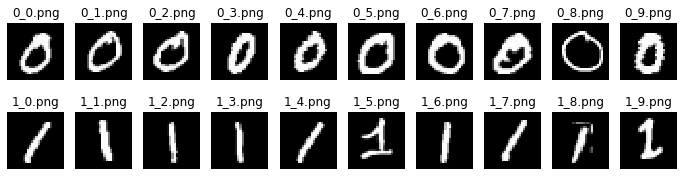

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

## 1.2 Fourier descriptors

### 1.2.1 Classic Fourier descriptors

Our first approach to this problem consists of extracting a shape's **Fourier descriptors** We first obtain each shape contours in sorted order, then we represent them in form of complex numbers and apply a Fourier transform in order to decompose this form. We take special care in order to make the descriptors rotation and translation invariant.

We also define several helper functions.

In [4]:
def orderRowsAndCols(rows_o,columns_o):
    """Return the rows and columns of the contour in the order that follows the contour
    Important for Fourier descriptors to work"""
    rows_ordered = np.zeros(rows_o.shape)
    cols_ordered = np.zeros(columns_o.shape)

    pts_together = np.zeros((len(rows_o),2))
    pts_together[:,0] = rows_o
    pts_together[:,1] = columns_o

    pt_on_contour = pts_together[0,:]
    pts_together = np.delete(pts_together,0,0)

    index = 0
    while pts_together.shape[0] != 0:
        rows_ordered[index] = pt_on_contour[0]
        cols_ordered[index] = pt_on_contour[1]
        distances = np.linalg.norm(pts_together - np.tile(pt_on_contour,(pts_together.shape[0],1)),axis=1)
        mn = np.argmin(distances)
        pt_on_contour = pts_together[mn,:]
        pts_together = np.delete(pts_together,mn,0)
        index += 1
    rows_ordered[index] = pt_on_contour[0]
    cols_ordered[index] = pt_on_contour[1]
    return rows_ordered, cols_ordered
    
def check_discriminatory_properties(features1,features2):
    """Perform a Kolomogorov-Smirinov test to check the extent to which two features are 
    linearly separable between two classes
    features[number of samples, number of features]
    features1 - class 1
    features2 - class 2"""
    for i in range (0,np.shape(features1)[1]):
        f1=features1[:,i]
        f2=features2[:,i]
        ks_test=stats.ks_2samp(f1,f2)
        print('KS1, feature number: '+ str(i),'results', ks_test[0])
        print('p value, feature number: '+ str(i),'results', ks_test[1])

In [5]:
def find_contour(original_im,threshold,name,flag):
    """Return the contours of an object"""
    retval, th = cv2.threshold(original_im, threshold, 255, cv2.THRESH_BINARY_INV)
    edge_rob = skimage.filters.roberts(th)
    indr=np.where(edge_rob!=0)[0]
    indc=np.where(edge_rob!=0)[1]
    
    im_edges = cv2.cvtColor(original_im, cv2.COLOR_GRAY2RGB)
    im_edges[edge_rob!=0,0]=254
    im_edges[edge_rob!=0,1]=127
    im_edges[edge_rob!=0,2]=156
    
    if flag==1:
        fig, axs = plt.subplots(1, 3, figsize=(17,12))
        axs[0].imshow(original_im, cmap = 'gray')
        axs[0].set_title('Original image - '+ name)
        axs[0].axis('off')

        axs[1].imshow(th, cmap = 'gray')
        axs[1].set_title("Thresholded - "+ name)
        axs[1].axis('off')


        axs[2].imshow(im_edges)
        axs[2].set_title("Detected edges - "+ name)
        axs[2].axis('off')

    ind_r=np.where(edge_rob!=0)[0]
    ind_c=np.where(edge_rob!=0)[1]
    return ind_r, ind_c


def plotFourierDescriptors(zeros_im, ones_im, second_label="zeros", first_label="ones", 
                           rotation_invariance=True, translation_invariance=True, scale_invariance=True):
    """Input two images and return their fourier descriptors based on the fourier transform of the ordered contour
    Optional inputs: making the fourier descriptors invariant to rotation and translation
    """
    plt.figure(figsize=(7,5))
    plt.title('Fourier descriptors - first two components')
    
    fouriers = np.zeros(((zeros_im.shape[0] + ones_im.shape[0]),10))
    labels = np.zeros(((zeros_im.shape[0] + ones_im.shape[0]),1))
    index=0
    
    
    labeled = False
    for im in ones_im:
        nm = 'name'
        [rows_o,columns_o]=find_contour(im,100,nm,0)
        rows_o,columns_o = orderRowsAndCols(rows_o,columns_o) #follow the contour
        contour_complex = np.empty(np.shape(rows_o), dtype=complex)
        contour_complex.real = rows_o
        contour_complex.imag = columns_o
        fourier_result = np.fft.fft(contour_complex)
        if scale_invariance:
            fourier_result = fourier_result/fourier_result[0]
        if rotation_invariance==True:
            fourier_result = np.absolute(fourier_result) #take magnitudes --> rotation invariance
        fourier_result = np.real(fourier_result)
        fouriers[index,:] = fourier_result[1:11]
        labels[index] = 1
        index += 1
        if translation_invariance==True:
            w1 = fourier_result[1] #ignore DC component --> translation invariance
            w2 = fourier_result[2]
        else:
            w1 = fourier_result[0] #first component = DC
            w2 = fourier_result[1]
        lines=plt.plot(w1,w2,'rD', label=first_label if not labeled else None)
        labeled = True

    labeled = False
    for im in zeros_im:
        zm = 'name'
        [rows_z,columns_z]=find_contour(im,100,zm,0)
        rows_z,columns_z = orderRowsAndCols(rows_z,columns_z) #follow the contour
        contour_complex = np.empty(np.shape(rows_z), dtype=complex)
        contour_complex.real = rows_z
        contour_complex.imag = columns_z
        fourier_result = np.fft.fft(contour_complex)
        if scale_invariance:
            fourier_result = fourier_result/fourier_result[0]
        if rotation_invariance==True:
            fourier_result = np.absolute(fourier_result) #take magnitudes --> rotation invariance
        fourier_result = np.real(fourier_result)
        fouriers[index,:] = fourier_result[1:11]
        index += 1
        if translation_invariance==True:
            w1 = fourier_result[1] #ignore DC component --> translation invariance
            w2 = fourier_result[2]
        else:
            w1 = fourier_result[0] #first component = DC
            w2 = fourier_result[1]
        lines=plt.plot(w1,w2,'bD', label=second_label if not labeled else None)
        labeled = True
        
    plt.legend()
    return fouriers, labels

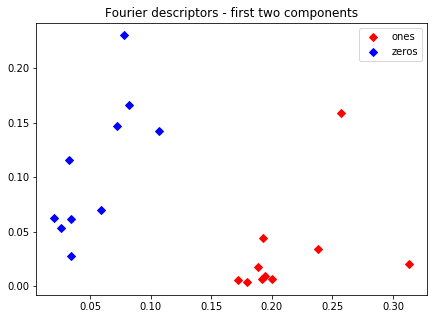

In [6]:
fourier_coeffs, labels = plotFourierDescriptors(zeros_im, ones_im)

First, we plot the first two Fourier descriptors without rotation, translation, or scale invariance.

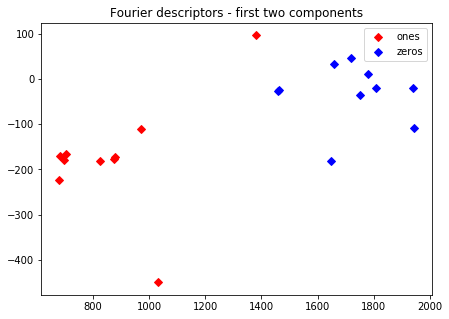

In [7]:
fourier_coeffs, labels = plotFourierDescriptors(zeros_im, ones_im,
                                                rotation_invariance=False,
                                                translation_invariance=False, scale_invariance=False)

We can see that there is a small separation between the ones and zeros, but the margin between the two classes is very small. Now, let's try adding rotation invariance.

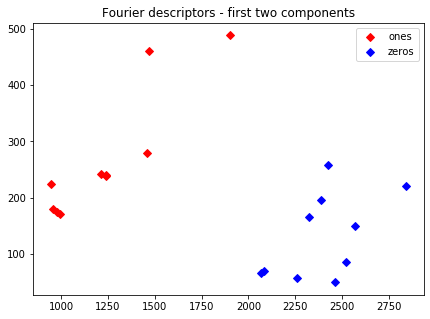

In [8]:
fourier_coeffs, labels = plotFourierDescriptors(zeros_im, ones_im, translation_invariance=False, scale_invariance=False)

This is much better! We now see a very large margin between the ones and zeros. However, these results are unstable because the first component is the DC offset, so any digits written with an offset would be outliers. Now, let's apply both rotation and translation invariance.

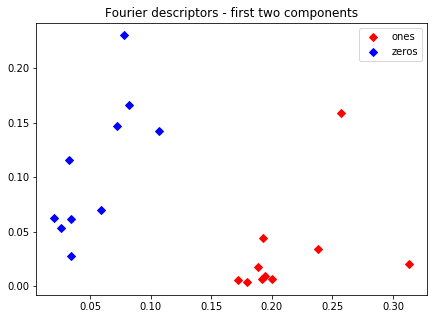

In [9]:
fourier_coeffs, labels = plotFourierDescriptors(zeros_im, ones_im)

We can see a clear separation between the two groups. In fact, after this transformation they have become linearly separable, and many ones and zeros are clustered together! 

### 1.2.2 Fourier Descriptors using morphological skeletons

We will now investigate how applying the Fourier descriptors to the skeletons of each image (obtained using mathematical morphology) changes the results.

In [10]:
# we first need to convert each image into a binary mask
binary_zeros_im = zeros_im > 192
binary_ones_im = ones_im > 192

zero_skeletons = np.zeros(zeros_im.shape)
one_skeletons = np.zeros(ones_im.shape)

# then, we can obtain each image's skeleton
for i in range(len(binary_zeros_im)):
    # perform skeletonization
    z_im = binary_zeros_im[i]
    z_skeleton = skeletonize(z_im)
    zero_skeletons[i] = z_skeleton
    o_im = binary_ones_im[i]
    o_skeleton = skeletonize(o_im)
    one_skeletons[i] = o_skeleton

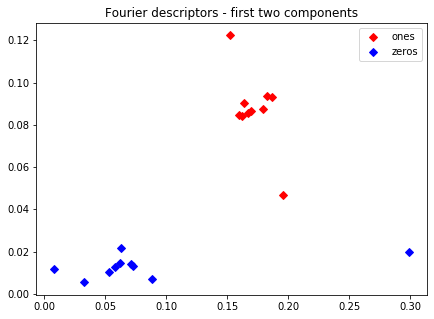

In [11]:
# fourierize skeletons
def fourierizeSkeletons(one_skeletons, zero_skeletons, second_label="zeros", first_label="ones", plot=True):
    "Compute the fourier coefficients of the morphological skeletons of images"
    if plot:
        plt.figure(figsize=(7,5))
        plt.title('Fourier descriptors - first two components')
    
    fouriers = np.zeros(((one_skeletons.shape[0] + zero_skeletons.shape[0]),10))
    labels = np.zeros(((one_skeletons.shape[0] + zero_skeletons.shape[0]),1))
    index=0
    
    labeled = False
    for im in one_skeletons:
        [rows_o, columns_o] = np.where(im>0)
        rows_o, columns_o = orderRowsAndCols(rows_o,columns_o) #follow the contour
        contour_complex = np.empty(np.shape(rows_o), dtype=complex)
        contour_complex.real = rows_o
        contour_complex.imag = columns_o
        fourier_result = np.fft.fft(contour_complex)
        fourier_result = fourier_result/fourier_result[0]
        fourier_result = np.absolute(fourier_result) #take magnitudes --> rotation invariance
        fouriers[index,:] = fourier_result[1:11]
        labels[index] = 1
        index += 1
        w1 = fourier_result[1] #ignore DC component --> translation invariance
        w2 = fourier_result[2]
        if plot:
            lines=plt.plot(w1,w2,'rD', label=first_label if not labeled else None)
        labeled = True

    labeled = False
    for im in zero_skeletons:
        [rows_z,columns_z]=np.where(im>0)
        rows_z,columns_z = orderRowsAndCols(rows_z,columns_z) #follow the contour
        contour_complex = np.empty(np.shape(rows_z), dtype=complex)
        contour_complex.real = rows_z
        contour_complex.imag = columns_z
        fourier_result = np.fft.fft(contour_complex)
        fourier_result = fourier_result/fourier_result[0]
        fourier_result = np.absolute(fourier_result) #take magnitudes --> rotation invariance
        fouriers[index,:] = fourier_result[1:11]
        index += 1
        w1 = fourier_result[1] #ignore DC component --> translation invariance
        w2 = fourier_result[2]
        if plot:
            lines=plt.plot(w1,w2,'bD', label=second_label if not labeled else None)
        labeled = True
        
    if plot:
            plt.legend()
    return fouriers, labels

fourier_sk, labels_sk = fourierizeSkeletons(one_skeletons,zero_skeletons)

Using the skeletons provides much tighter clusters, but a couple of outliers also become much more noticeable. Overall, it appears that the two categories have a smaller separation margin, when compared to their non-skeletonized counterparts.

### 1.2.3 Fourier descriptors with PCA

Let us examine the result of applying Principle Component Analysis (with 2 components) to the result of Fourier descriptors, instead of simply using the first two descriptors.

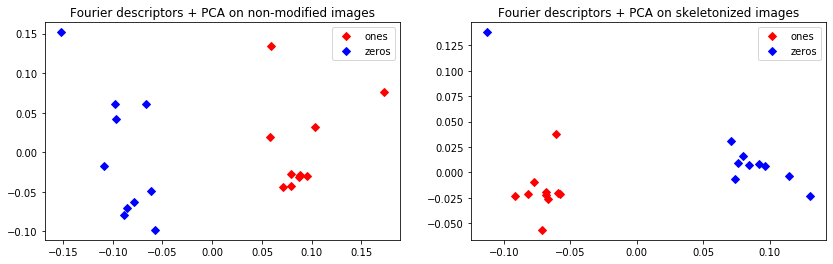

In [12]:
def fourierPCA(fourier_coeffs, labels, ax, first_label="zeros", second_label="ones"):
    pca = PCA(n_components=2)
    pca.fit(fourier_coeffs)
    fourier_pca = pca.transform(fourier_coeffs)
    z_labeled = o_labeled = False
    for i in range(len(labels)):
        pt = fourier_pca[i]
        if labels[i] == 0:
            ax.plot(pt[0],pt[1],'bD', label=first_label if not o_labeled else None)
            o_labeled = True
        else:
            ax.plot(pt[0],pt[1],'rD', label=second_label if not z_labeled else None)
            z_labeled = True
    ax.legend()   
    
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fourierPCA(fourier_coeffs, labels, axes[0])
fourierPCA(fourier_sk, labels_sk, axes[1])
axes[0].set_title('Fourier descriptors + PCA on non-modified images')
axes[1].set_title('Fourier descriptors + PCA on skeletonized images')
plt.show()

We can observe similar results for the non-modified images with a slightly larger separation margin, and nearly identical ones for the skeletonized ones. This may be because the Fourier components are already ordered in terms of decreasing variance, as they form a basis for the eigenspace of the Fourier descriptors, so applying PCA does not help much.

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

## 1.3 Additional method(s)

We first define some helper functions that will later be used.

In [13]:
def plot_2D(values1, values2, values3, values4, title_, labels, ax=None):
    """The function makes 2D scatter plot of features.
    values1=features that will be shown on x axis - class 1
    values2=features that will be shown on y axis - class 1
    values3=features that will be shown on x axis - class 2
    values4=features that will be shown on y axis - class 2
    title= title in string form,
    labels=['label1','labels2']"""
    
    if ax:
        ax.set_title(title_)
        labeled = False
        for i in range(len(values1)):
            ax.plot(values1[i],values2[i],'cD', label=labels[0] if not labeled else None)
            labeled = True

        labeled = False
        for i in range(len(values3)):
            ax.plot(values3[i],values4[i],'mD', label=labels[1] if not labeled else None)
            labeled = True
            
        
    else:
        plt.figure(figsize=(7,5))
        plt.title(title_)
        labeled = False
        for i in range(len(values1)):
            lines=plt.plot(values1[i],values2[i],'cD', label=labels[0] if not labeled else None)
            labeled = True

        labeled = False
        for i in range(len(values3)):
            lines=plt.plot(values3[i],values4[i],'mD', label=labels[1] if not labeled else None)
            labeled = True

        plt.legend()
        plt.show()

### 1.3.1 Freeman coding

We take the ordered list of coordinates of the contours and transform it into a freeman code, which calculates the relative direction from one point to the next. There are eight possible directions, each spaced 45 degrees apart. We then look at the relative frequencies of each direction on the skeletons of the images (i.e. ones go mainly from up to down so the downward freeman value should be much more frequent than the rest, while 3 goes sideways so its freeman values should be a bit more equal).

Note that we implement a discriminatory properties test, using the Kolmogorov-Smirinov (KS) test. In cases we find more than 2 features, we apply it to get an insight into how well features are able to divide two classes, based on the dataset. If the result of the KS test is 1 (and hence p value is small), this means that a certain 1D feature is able to distinguish two classes without overlapping. The lower the result, the less discriminatory properties feature holds.  

In [14]:
def getFreemanCode(rows,cols):
    "input rows and columns IN ORDER of a contour and output its freeman code"
    freeman_output = np.zeros((len(rows)-1,1))
    angles = np.array([        0, PI/4, PI/2, 3*PI/4, PI, -PI, -3*PI/4, -PI/2, -PI/4 ])
    freeman_values = np.array([0, 1,    2,    3,      4,   4,   5,       6,     7   ])
    for n in range(len(rows)-1):
        first_pt = np.array([cols[n], rows[n]])
        second_pt = np.array([cols[n+1], rows[n+1]])
        d = second_pt - first_pt
        angle = math.atan2(d[1],d[0])
        min_dist_ndx = np.argmin(np.abs(angles - angle))
        freeman_val = freeman_values[min_dist_ndx]
        freeman_output[n] = freeman_val
    return freeman_output
 

def compareRelativeFreemanValues(zero_im,one_im):
    """Output eight values, which correspond to the normalized counts of the freeman 
    code values that make up the image"""
    norm_counts = np.zeros(((one_im.shape[0] + zero_im.shape[0]),8))
    labels = np.zeros(((one_im.shape[0] + zero_im.shape[0]),1))
    
    for i in range(zero_im.shape[0]):
        zm = 'name'
        [rows_o,columns_o]=find_contour(zero_im[i],100,zm,0)
        rows_o,columns_o = orderRowsAndCols(rows_o,columns_o) #follow the contour
        freeman_vals = getFreemanCode(rows_o,columns_o)
        values, counts = np.unique(freeman_vals, return_counts=True)
        normalized_counts = counts/sum(counts)
        final_counts = np.zeros(8)
        for v in range(len(values)):
            val = values[v]
            final_counts[int(val)] = normalized_counts[v]
        norm_counts[i,:] = final_counts
    
    for i in range(one_im.shape[0]):
        zm = 'name'
        [rows_o,columns_o]=find_contour(one_im[i],100,zm,0)
        rows_o,columns_o = orderRowsAndCols(rows_o,columns_o) #follow the contour
        freeman_vals = getFreemanCode(rows_o,columns_o)
        values, counts = np.unique(freeman_vals, return_counts=True)
        normalized_counts = counts/sum(counts)
        final_counts = np.zeros(8)
        for v in range(len(values)):
            val = values[v]
            final_counts[int(val)] = normalized_counts[v]
        norm_counts[i+zero_im.shape[0],:] = final_counts
        labels[i+zero_im.shape[0]] = 1
    return norm_counts, labels

def compareRelativeFreemanValuesSkeleton(zero_skeletons,one_skeletons):
    """Output eight values, which correspond to the normalized counts of the freeman 
    code values that make up the morphological skeleton of the image"""
    norm_counts = np.zeros(((one_skeletons.shape[0] + zero_skeletons.shape[0]),8))
    labels = np.zeros(((one_skeletons.shape[0] + zero_skeletons.shape[0]),1))
    
    for i in range(zero_skeletons.shape[0]):
        im = zero_skeletons[i]
        [rows_o,columns_o]=np.where(im>0)
        rows_o,columns_o = orderRowsAndCols(rows_o,columns_o) #follow the contour
        freeman_vals = getFreemanCode(rows_o,columns_o)
        values, counts = np.unique(freeman_vals, return_counts=True)
        normalized_counts = counts/sum(counts)
        final_counts = np.zeros(8)
        for v in range(len(values)):
            val = values[v]
            final_counts[int(val)] = normalized_counts[v]
        norm_counts[i,:] = final_counts
    
    for i in range(one_skeletons.shape[0]):
        im = one_skeletons[i]
        [rows_o,columns_o]=np.where(im>0)
        rows_o,columns_o = orderRowsAndCols(rows_o,columns_o) #follow the contour
        freeman_vals = getFreemanCode(rows_o,columns_o)
        values, counts = np.unique(freeman_vals, return_counts=True)
        normalized_counts = counts/sum(counts)
        final_counts = np.zeros(8)
        for v in range(len(values)):
            val = values[v]
            final_counts[int(val)] = normalized_counts[v]
        norm_counts[i+zero_skeletons.shape[0],:] = final_counts
        labels[i+zero_skeletons.shape[0]] = 1
    return norm_counts, labels

KS1, feature number: 0 results 0.8
p value, feature number: 0 results 0.002056766762649115
KS1, feature number: 1 results 0.6
p value, feature number: 1 results 0.05244755244755244
KS1, feature number: 2 results 0.9
p value, feature number: 2 results 0.00021650176448938054
KS1, feature number: 3 results 0.4
p value, feature number: 3 results 0.41752365281777043
KS1, feature number: 4 results 0.7
p value, feature number: 4 results 0.012340600575894691
KS1, feature number: 5 results 1.0
p value, feature number: 5 results 1.0825088224469026e-05
KS1, feature number: 6 results 1.0
p value, feature number: 6 results 1.0825088224469026e-05
KS1, feature number: 7 results 1.0
p value, feature number: 7 results 1.0825088224469026e-05


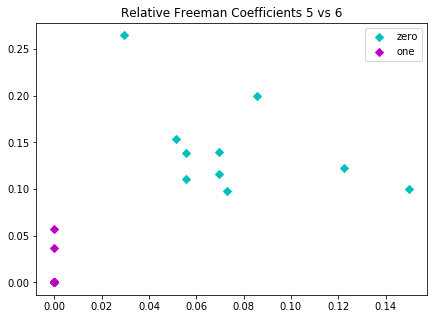

In [15]:
norm_counts, labels = compareRelativeFreemanValuesSkeleton(zero_skeletons,one_skeletons)

# compute p-values of the features to find discriminative relative freeman values
ft_1 = norm_counts[0:10,:]
ft_2 = norm_counts[10:20,:]
check_discriminatory_properties(ft_1,ft_2)

plot_2D(norm_counts[0:10,5], norm_counts[0:10,6], norm_counts[10:20,5], norm_counts[10:20,6],
        'Relative Freeman Coefficients 5 vs 6',['zero','one'])

We see from the Kolomogorov-Smirinov test that the fifth and sixth relative Freeman code value counts form a perfect linear separation between ones and zeros, since their p-values are very small. Futhermore, we can see that most ones are all clustered together, since their freeman code should mostly be composed of the downward direction.

### 1.3.2 Hu Moments

Hu moments are a set of seven moments that are rotation, translation and scale invariant. Let us see how they fare in separating `zeros` from `ones`.

In [16]:
def compute_HU_moments(images1,images2):
    
    HMo=np.zeros((np.shape(images1)[0],7))
    import cv2
    threshold=100
    ind=0
    for im in images1:
        retval, th = cv2.threshold(im, threshold, 255,0)# cv2.THRESH_BINARY_INV)
        mom = cv2.moments(th)
        huMoments = cv2.HuMoments(mom)
        for i in range (0,np.shape(huMoments)[0]):
            hmlog=-1*np.sign(huMoments[i])*np.log10(abs(huMoments[i]))
            huMoments[i]=hmlog
            HMo[ind,i]=hmlog
        ind+=1

    HMz=np.zeros((np.shape(zeros_im)[0],7))
    ind=0
    for im in images2:
        retval, th = cv2.threshold(im, threshold, 255,0)# cv2.THRESH_BINARY_INV)
        mom = cv2.moments(th)
        huMoments = cv2.HuMoments(mom)
        for i in range (0,np.shape(huMoments)[0]):
            hmlog=-1*np.sign(huMoments[i])*np.log10(abs(huMoments[i]))
            huMoments[i]=hmlog
            HMz[ind,i]=hmlog
        ind+=1
    
    return HMo, HMz

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    # Calculate affine transform to correct skewness.
    SZ=np.shape(img)[0]
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    # Apply affine transform
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

KS1, feature number: 0 results 0.8
p value, feature number: 0 results 0.002056766762649115
KS1, feature number: 1 results 1.0
p value, feature number: 1 results 1.0825088224469026e-05
KS1, feature number: 2 results 0.6
p value, feature number: 2 results 0.05244755244755244
KS1, feature number: 3 results 0.4
p value, feature number: 3 results 0.41752365281777043
KS1, feature number: 4 results 0.5
p value, feature number: 4 results 0.16782134274394334
KS1, feature number: 5 results 0.7
p value, feature number: 5 results 0.012340600575894691
KS1, feature number: 6 results 0.5
p value, feature number: 6 results 0.16782134274394334


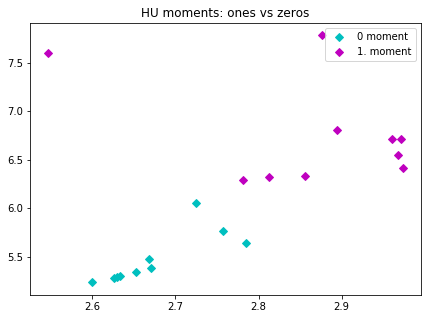

In [17]:
HM1,HM2=compute_HU_moments(ones_im,zeros_im)

check_discriminatory_properties(HM1,HM2)

title_='HU moments: ones vs zeros'
labels=['0 moment','1. moment']
plot_2D(HM1[:,0], HM1[:,1], HM2[:,0], HM2[:,1], title_, labels)

Similarly to what we did with the Freeman code values, we select the two features (Hu moments 0 and 1) with the lowest p-values and plot them. We see that the ones and zeros are linearly separable.

### 1.3.3 Average Image Convolution

Here, we will convolve each image with two template images. From resulting image we then derive 14 features, which will allow us to create a good estimate of the class of the original image.

Let us begin by creating the templates. We will do this by finding the average image for each of the classes, after deskewing each image.

(-0.5, 27.5, 27.5, -0.5)

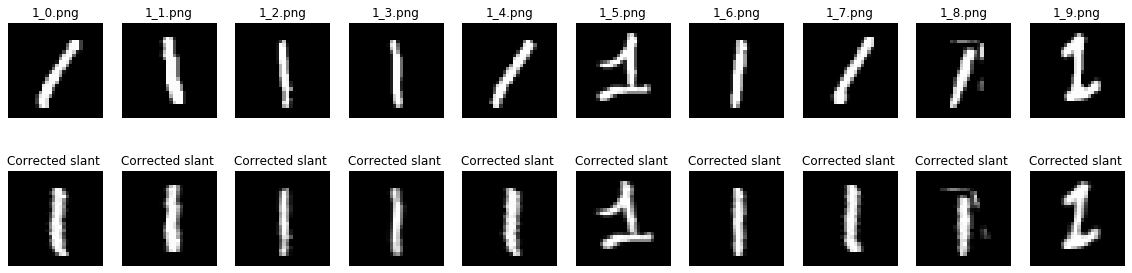

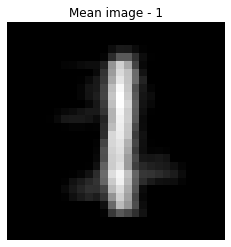

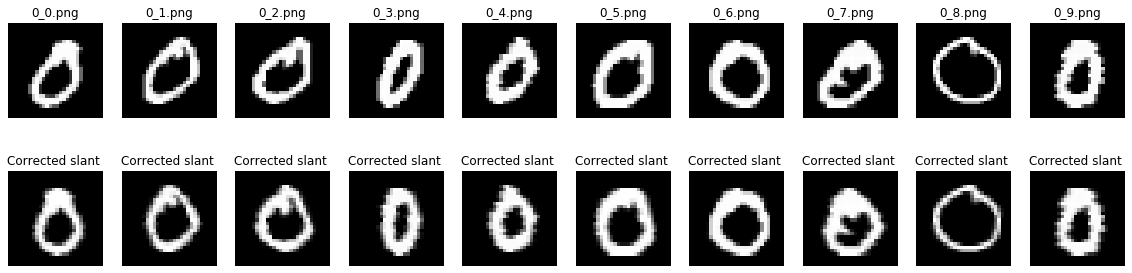

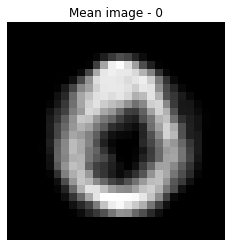

In [18]:
# deskew and find average image
ones_imc=ones_im.copy()
zeros_imc=zeros_im.copy()
threshold=100
i=0
fig, axs = plt.subplots(2, 10, figsize=(20,5))
for im, on in zip(ones_im, ones_names):
    res=deskew(im)
    retval, th = cv2.threshold(res, threshold, 255, cv2.THRESH_BINARY_INV)
    axs[0,i].imshow(im, cmap = 'gray')
    axs[0,i].set_title(on)
    axs[0,i].axis('off')
    axs[1,i].imshow(res, cmap = 'gray')
    axs[1,i].set_title('Corrected slant ')
    axs[1,i].axis('off')
    ones_imc[i]=res
    i+=1
mean_ones=np.mean(ones_imc,axis=0)
plt.figure()
plt.imshow(mean_ones,cmap='gray')
plt.title('Mean image - 1')
plt.axis('off')
    
i=0
fig, axs = plt.subplots(2, 10, figsize=(20,5))
for im, on in zip(zeros_im, zeros_names):
    res=deskew(im)
    axs[0,i].imshow(im, cmap = 'gray')
    axs[0,i].set_title(on)
    axs[0,i].axis('off')
    axs[1,i].imshow(res, cmap = 'gray')
    axs[1,i].set_title('Corrected slant ')
    axs[1,i].axis('off')
    zeros_imc[i]=res
    i+=1
    
mean_zeros=np.mean(zeros_imc,axis=0)
plt.figure()
plt.imshow(mean_zeros,cmap='gray')
plt.title('Mean image - 0')
plt.axis('off')

We will now convolve each image with the 2 template images, mean imahe-1 ( `template0`) and mean image-0 (`template1`). From resulting image we derive 14 features: 4 `standard deviations` (2 convolutional images x 2 dimensions),  4 `kurtosis coefficients` (2 convolutional images x 2 dimensions),  4 `skewness coefficients` (2 convolutional images x 2 dimensions), and 2 `number of pixels` (2 convolutional images). 

The reasoning is intuitive: the convolution of `template1` and an image that represents an `one` will have high values somewhere in the middle. Thus, by thresholding, a regular pattern (i.e. a circle, a rectangle, etc.) will be obtained. On the other hand, convolution of `template0` and an image that represents an `one` will result in random pattern. By looking at standard deviation of shapes or simply number of pixels of thresholded convolutional image the difference should be evident. Besides standard deviation, we also compute two other statistical properties, kurtosis and skewness. 

In [19]:
def scale_range(M):
    to_sub=min(M.flatten())
    Msub=M-to_sub
    to_div=max(Msub.flatten())
    Mscaled=Msub/to_div
    return Mscaled

def mean_sv(M):
    c1=np.mean(M,axis=0)
    c2=np.mean(M,axis=1)
    sd1 = np.std(c1)#, fisher=True)
    sd2 = np.std(c2)#, fisher=True)  
    return sd1, sd2

def k_skw(M):
    c1=np.mean(M,axis=0)
    c2=np.mean(M,axis=1)
    k1=kurtosis(c1)
    k2=kurtosis(c2)
    skw1=skew(c1)
    skw2=skew(c2)
    return k1,k2,skw1,skw2


def conv_features(mean_1,mean_2,image,flag1,flag2):

    threshold=100#160
    retval, mean_1_th = cv2.threshold(mean_1, threshold, 255, cv2.THRESH_BINARY_INV)
    retval, mean_2_th = cv2.threshold(mean_2, threshold, 255, cv2.THRESH_BINARY_INV)
    threshold=100
    retval, im_th = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY_INV)

    #convolve
    conv1=signal.convolve2d(im_th,mean_1_th,boundary='symm', mode='same')
    conv2=signal.convolve2d(im_th,mean_2_th,boundary='symm', mode='same')

    #scale to range 0-1
    C1=scale_range(conv1)
    C2=scale_range(conv2)
    
    #show convolution result      
    if flag1==1:
        fig, axs = plt.subplots(1, 2, figsize=(20,5))
        axs[0].imshow(conv1, cmap = 'gray')
        axs[0].set_title('C1')
        axs[0].axis('off')
        axs[1].imshow(conv2, cmap = 'gray')
        axs[1].set_title('C2')
        axs[1].axis('off')
    
    
    #threshold with 0.8
    retval, th1 = cv2.threshold(C1, 0.8*max(C1.flatten()), 1, cv2.THRESH_BINARY_INV)
    retval, th2 = cv2.threshold(C2, 0.8*max(C2.flatten()), 1, cv2.THRESH_BINARY_INV)
    
    if flag2==1:
        fig, axs = plt.subplots(1, 2, figsize=(20,5))
        axs[0].imshow(th1, cmap = 'gray')
        axs[0].set_title('C1 thresholded')
        axs[0].axis('off')
        axs[1].imshow(th2, cmap = 'gray')
        axs[1].set_title('C2 thresholded')
        axs[1].axis('off')

    s1=sum(sum(th1))
    s2=sum(sum(th2))
    #compute SD, if image matches template we expect thresholded convolution to be
    #regular shape, otherwise it is random pattern with larger variance
    sd1,sd2=mean_sv(C1)#th1
    sd3,sd4=mean_sv(C2)#th2
    k1,k2,skw1,skw2=k_skw(C1)
    k3,k4,skw3,skw4=k_skw(C2)

    f=[sd1, sd2,sd3,sd4,k1,k2,skw1,skw2,k3,k4,skw3,skw4,s1,s2]

    return f

Finally, we can analyze the results of Kolmogorov-Smirinov test, with respect to this approach:

KS1, feature number: 0 results 0.9
p value, feature number: 0 results 0.00021650176448938054
KS1, feature number: 1 results 0.7
p value, feature number: 1 results 0.012340600575894691
KS1, feature number: 2 results 0.5
p value, feature number: 2 results 0.16782134274394334
KS1, feature number: 3 results 0.9
p value, feature number: 3 results 0.00021650176448938054
KS1, feature number: 4 results 0.6
p value, feature number: 4 results 0.05244755244755244
KS1, feature number: 5 results 0.6
p value, feature number: 5 results 0.05244755244755244
KS1, feature number: 6 results 0.6
p value, feature number: 6 results 0.05244755244755244
KS1, feature number: 7 results 0.5
p value, feature number: 7 results 0.16782134274394334
KS1, feature number: 8 results 0.9
p value, feature number: 8 results 0.00021650176448938054
KS1, feature number: 9 results 0.4
p value, feature number: 9 results 0.41752365281777043
KS1, feature number: 10 results 0.8
p value, feature number: 10 results 0.0020567667626491

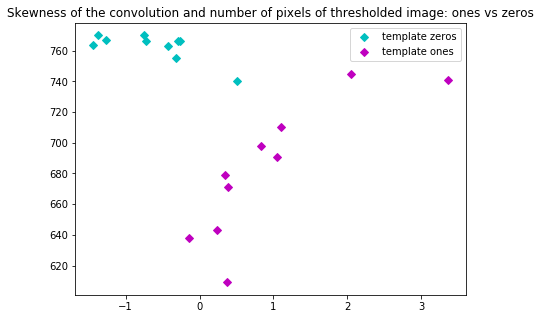

In [20]:
f1=np.zeros((10,14))
i=0
for im, on in zip(zeros_imc, zeros_names):
    fi=conv_features(mean_zeros,mean_ones,im,0,0)
    f1[i,:]=fi
    i+=1


f2=np.zeros((10,14))
i=0
for im, on in zip(ones_imc, ones_names):
    fi=conv_features(mean_zeros,mean_ones,im,0,0)
    #f2[i,0]=sd1#(sd1+sd2)/2
    #f2[i,1]=sd2#(sd3+sd4)/2
    #f2[i,2]=sd3#(sd1+sd2)/2
    #f2[i,3]=sd4#(sd3+sd4)/2
    #f2[i,4]=s1#(sd1+sd2)/2
    #f2[i,5]=s2#(sd3+sd4)/2
    f2[i,:]=fi
    i+=1


    
check_discriminatory_properties(f1,f2)

title_='Skewness of the convolution and number of pixels of thresholded image: ones vs zeros'
labels=['template zeros','template ones']
plot_2D(f1[:,8],f1[:,12],f2[:,8],f2[:,12],title_,labels)

The results are very satisfactory: for this test, a result of 1 means that classes are linearly separable based solely on the corresponding feature. Values close to 1, like 0.8, 0.9 are significant, and promising as well. We select the eighth and twelfth features, resulting in linear separability between the classes.

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

## A. Appendix for Part 1

Below we showcase several methods also attempted, but that in the end did not provide results as interesting or promising as those in section 1.3. Furthermore, we verify several key properties of the methods we implemented, such as the Fourier descriptors invariance to changes in the images.

### A.1 Fourier Descriptors - verifications

In this section, we will load translated, rotated and scaled images of `zeros` and `ones`. We will then apply Fourier descriptors with rotation and translation invariance onto them, in order to guarantee these invariances work correctly and as expected.

In [21]:
# load images
mod_zeros = { 'rotated':[], 'translated':[]}
mod_ones = {'rotated':[], 'translated':[]}

# load zeros
for key in ['rotated', 'translated']:
    zeros_path = 'modified_imgs/{0}/zeros'.format(key)
    zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
    ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
    mod_zeros[key] = skimage.io.concatenate_images(ic)

# load ones
for key in ['rotated', 'translated']:
    ones_path = f'./modified_imgs/{key}/ones'
    ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
    ic = skimage.io.imread_collection([os.path.join(ones_path, nm) for nm in ones_names])
    mod_ones[key] = skimage.io.concatenate_images(ic)

Text(0.5, 1.0, 'Rotated 0')

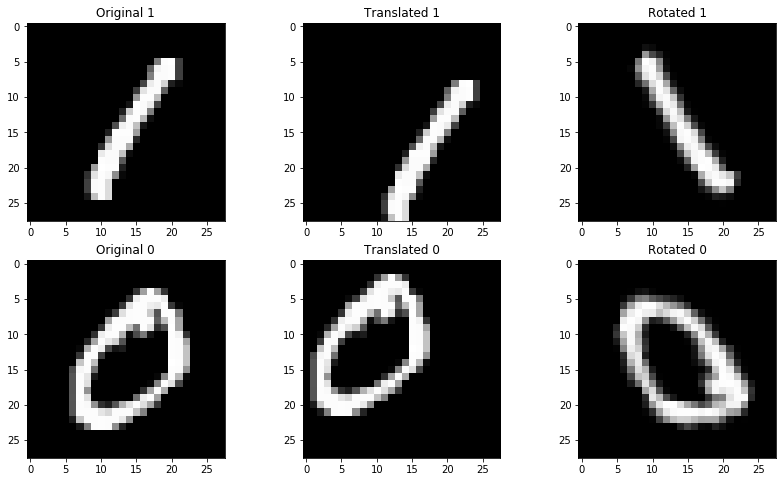

In [22]:
#image change visualization
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes[0][0].imshow(ones_im[0,:,:],cmap='gray')
axes[0][0].set_title('Original 1')
axes[0][1].imshow(mod_ones['translated'][0,:,:],cmap='gray')
axes[0][1].set_title('Translated 1')
axes[0][2].imshow(mod_ones['rotated'][0,:,:],cmap='gray')
axes[0][2].set_title('Rotated 1')

axes[1][0].imshow(zeros_im[1,:,:],cmap='gray')
axes[1][0].set_title('Original 0')
axes[1][1].imshow(mod_zeros['translated'][1,:,:],cmap='gray')
axes[1][1].set_title('Translated 0')
axes[1][2].imshow(mod_zeros['rotated'][1,:,:],cmap='gray')
axes[1][2].set_title('Rotated 0')

##### Translation invariance
We plot the translated images before and after applying translation invariance. Once the CV coefficient is removed, we see that the image reverts to the same pattern we saw in Section 1.2.1.

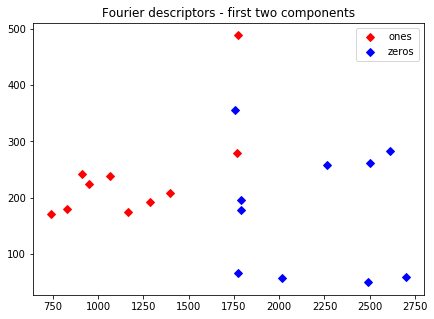

In [23]:
#No translation invariance
fourier_coeffs, labels = plotFourierDescriptors(mod_zeros['translated'], 
                                                mod_ones['translated'],
                                                rotation_invariance=True,
                                                translation_invariance=False,scale_invariance=False)

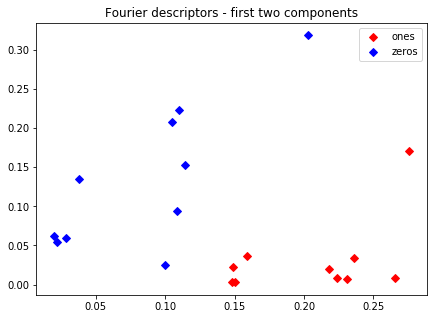

In [24]:
#Translation invariance applied
fourier_coeffs, labels = plotFourierDescriptors(mod_zeros['translated'], 
                                                mod_ones['translated'],
                                                rotation_invariance=True,
                                                translation_invariance=True, scale_invariance=True)

##### Rotation invariance
Similarly, we rotate the images and then apply the Fourier descriptor transform. We see that after applying rotation invariance, the graph looks like that of the translated images once translation invariance is applied.

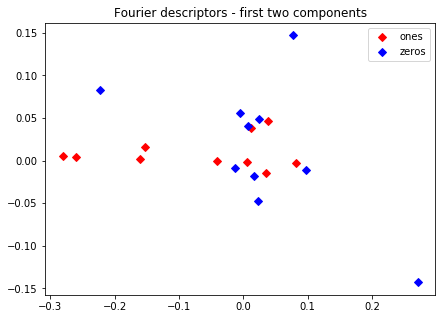

In [25]:
#No rotation invariance
fourier_coeffs, labels = plotFourierDescriptors(mod_zeros['rotated'], 
                                                mod_ones['rotated'],
                                                rotation_invariance=False,
                                                translation_invariance=True, scale_invariance=True)

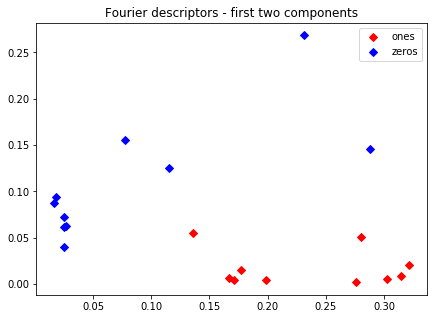

In [26]:
#Rotation invariance applied
fourier_coeffs, labels = plotFourierDescriptors(mod_zeros['rotated'], 
                                                mod_ones['rotated'],
                                                rotation_invariance=True,
                                                translation_invariance=True, scale_invariance=True)

### A.2 Mathematical Morphology - Skeletons

We will first obtain and display the mathematical morphology skeletons obtained from the images. These skeletons represent the components of the shape that could not be further reduced, and are comprised of lines 1 pixel thick.

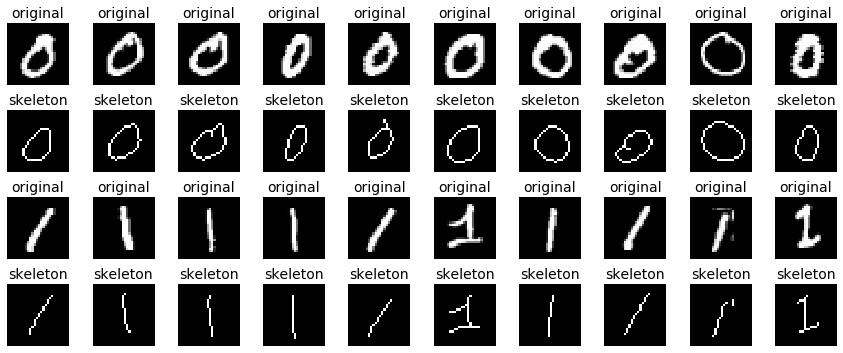

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=len(binary_zeros_im), figsize=(12, 5), sharex=True, sharey=True)

# we first need to convert each image into a binary mask
binary_zeros_im = zeros_im > 192
binary_ones_im = ones_im > 192

# then, we can obtain each image's skeleton
for i in range(len(binary_zeros_im)):
    # perform skeletonization
    z_im = binary_zeros_im[i]
    z_skeleton = skeletonize(z_im)
    o_im = binary_ones_im[i]
    o_skeleton = skeletonize(o_im)

    # display results
    axes[0][i].imshow(zeros_im[i], cmap=plt.cm.gray)
    axes[0][i].axis('off')
    axes[0][i].set_title('original', fontsize=14)
    axes[1][i].imshow(z_skeleton, cmap=plt.cm.gray)
    axes[1][i].axis('off')
    axes[1][i].set_title('skeleton', fontsize=14)
    axes[2][i].imshow(ones_im[i], cmap=plt.cm.gray)
    axes[2][i].axis('off')
    axes[2][i].set_title('original', fontsize=14)
    axes[3][i].imshow(o_skeleton, cmap=plt.cm.gray)
    axes[3][i].axis('off')
    axes[3][i].set_title('skeleton', fontsize=14)

fig.tight_layout()
plt.show()

### A.3 Major and minor axis

Next, we examine the major and minor axis in both categories, as well as the diference between these two categories.

The major axis represents the longest line that can be traced through the object, and the minor axis is the longest line that can be traced through the object whilst remaining perpendicular to the major axis.

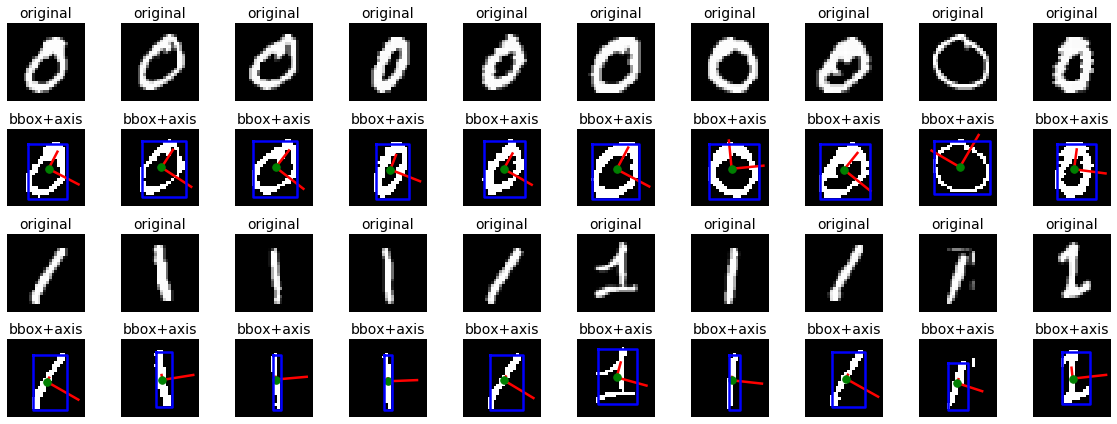

In [28]:
fig, axes = plt.subplots(nrows=4, ncols=len(binary_zeros_im), figsize=(16, 6), sharex=True, sharey=True)

for i in range(len(binary_zeros_im)):
    # perform binarization
    z_im = binary_zeros_im[i]
    o_im = binary_ones_im[i]
    
    # extract shapes
    z_label_img = label(z_im)
    z_regions = regionprops(z_label_img)
    o_label_img = label(o_im)
    o_regions = regionprops(o_label_img)

    axes[1][i].imshow(z_im, cmap=plt.cm.gray)
    axes[1][i].axis('off')
    axes[1][i].set_title('bbox+axis', fontsize=14)
    axes[3][i].imshow(o_im, cmap=plt.cm.gray)
    axes[3][i].axis('off')
    axes[3][i].set_title('bbox+axis', fontsize=14)
    
    # obtain the major and minor axes, bounding boxes and center for each shape
    for props in [z_regions[-1]]:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

        axes[1][i].plot((x0, x1), (y0, y1), '-r', linewidth=2.5) # major axis
        axes[1][i].plot((x0, x2), (y0, y2), '-r', linewidth=2.5) # minor axis
        axes[1][i].plot(x0, y0, '.g', markersize=15) # center

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        axes[1][i].plot(bx, by, '-b', linewidth=2.5)  # bounding box
        
    for props in [o_regions[-1]]:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

        axes[3][i].plot((x0, x1), (y0, y1), '-r', linewidth=2.5) # major axis
        axes[3][i].plot((x0, x2), (y0, y2), '-r', linewidth=2.5) # minor axis
        axes[3][i].plot(x0, y0, '.g', markersize=15) # center

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        axes[3][i].plot(bx, by, '-b', linewidth=2.5) # bounding box

    
    # display original images
    axes[0][i].imshow(zeros_im[i], cmap=plt.cm.gray)
    axes[0][i].axis('off')
    axes[0][i].set_title('original', fontsize=14)
    axes[2][i].imshow(ones_im[i], cmap=plt.cm.gray)
    axes[2][i].axis('off')
    axes[2][i].set_title('original', fontsize=14)

fig.tight_layout()
plt.show()

### A.4 Eccentricity

By analyzing the ratio between the minor and major axis, we can spot a clear difference between the zeros and ones.

In [29]:
print('\033[1mFor zero images:\033[0m')
zero_ratio_tops = 0
zero_ratio_bots = 0
zero_ratios = []
for i in range(len(binary_zeros_im)):
    z_im = binary_zeros_im[i]
    z_label_img = label(z_im)
    z_regions = regionprops(z_label_img)
    
    for props in [z_regions[-1]]:
        zero_ratio_tops += props.minor_axis_length
        zero_ratio_bots += props.major_axis_length
        ratio = props.minor_axis_length/props.major_axis_length
        zero_ratios.append(ratio)
        print(f'\t\tratio: {ratio}')
print(f'\033[1m\taverage ratio: {zero_ratio_tops/zero_ratio_bots}\033[0m')

print('\n\033[1mFor one images:\033[0m')
one_ratio_tops = 0
one_ratio_bots = 0
one_ratios = []
for i in range(len(binary_zeros_im)):
    o_im = binary_ones_im[i]
    o_label_img = label(o_im)
    o_regions = regionprops(o_label_img)
    
    for props in [o_regions[-1]]:
        one_ratio_tops += props.minor_axis_length
        one_ratio_bots += props.major_axis_length
        ratio = props.minor_axis_length/props.major_axis_length
        one_ratios.append(ratio)
        print(f'\t\tratio: {ratio}')
print(f'\033[1m\taverage ratio: {one_ratio_tops/one_ratio_bots}\033[0m')

For zero images:
		ratio: 0.5713419703124062
		ratio: 0.5946171487717206
		ratio: 0.6136808288720635
		ratio: 0.4908841145292688
		ratio: 0.5520534259492197
		ratio: 0.6679803928222957
		ratio: 0.8862166768362643
		ratio: 0.6308744169777778
		ratio: 0.8803771581377718
		ratio: 0.6286049412597183
	average ratio: 0.6539145448332963

For one images:
		ratio: 0.1285010839393565
		ratio: 0.1583049824217568
		ratio: 0.08751590488027847
		ratio: 0.09623204649559247
		ratio: 0.12141392539390142
		ratio: 0.49877328176576624
		ratio: 0.10860688868757731
		ratio: 0.11746166989268739
		ratio: 0.15442312190587484
		ratio: 0.3254648983732565
	average ratio: 0.1789847852691294


Though eccentricity is a one dimensional feature, it is much easier to visualize in a plot rather than in a list format. Below, we plot the eccentricity values obtained for the `zeros` at $x = 0$, and the values obtained for `ones` at $x = 1$.

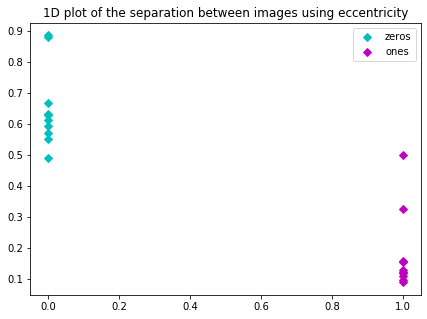

In [30]:
nb_images = len(zero_ratios)
plot_2D([0]*nb_images,zero_ratios,[1]*nb_images,one_ratios,
        "1D plot of the separation between images using eccentricity", labels=['zeros', 'ones'])

Indeed the ellipticity of zeros is usually above 0.4, or even 0.45, whereas that of ones is usually well below it (there is one exception, preventing liner separability: the sixth ones' image, pictured again below).

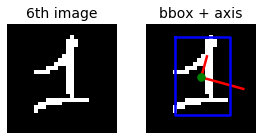

In [31]:
o_im = binary_ones_im[5]
o_label_img = label(o_im)
o_regions = regionprops(o_label_img)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), sharex=True, sharey=True)
ax = axes.ravel()

ax[1].imshow(o_im, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('bbox + axis', fontsize=14)

for props in [o_regions[-1]]:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

    ax[1].plot((x0, x1), (y0, y1), '-r', linewidth=2.5) # major axis
    ax[1].plot((x0, x2), (y0, y2), '-r', linewidth=2.5) # minor axis
    ax[1].plot(x0, y0, '.g', markersize=15) # center

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax[1].plot(bx, by, '-b', linewidth=2.5)  # bounding box



# display original image
ax[0].imshow(o_im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('6th image', fontsize=14)

fig.tight_layout()
plt.show()

We can indeed observe that this `one` has a much rounder shape than the more common, more vertical one.

### A.5 Elongation

`skimage`'s `inertia_tensor_eigvals` method returns the eigenvalues of the inertia tensor of image (in descending order). The relative magnitude of these eigenvalues can be used as a measure of the elongation of a (bright) object in the image (since the inertia tensor measures the covariance of the image intensity along the image axes).

*(Based on `skimage`'s documentation.)*

In [32]:
print('\033[1mFor zero images:\033[0m')
zero_vals = []
for i in range(len(binary_zeros_im)):
    tensors = inertia_tensor_eigvals(binary_zeros_im[i])
    zero_vals.append(tensors)
    print(f'\t\ttensors: {tensors}')    
print(f'\033[1m\taverage tensors: {np.average(zero_vals, axis=0)}\033[0m')

print('\n\033[1mFor one images:\033[0m')
one_vals = []
for i in range(len(binary_zeros_im)):
    tensors = inertia_tensor_eigvals(binary_ones_im[i])
    one_vals.append(tensors)
    print(f'\t\ttensors: {tensors}')
print(f'\033[1m\taverage tensors: {np.average(one_vals, axis=0)}\033[0m')

For zero images:
		tensors: [37.20370810034137, 12.144467711207028]
		tensors: [41.10315931510487, 14.532825691142525]
		tensors: [39.92026622078199, 15.034138316080014]
		tensors: [33.23435415874666, 8.008389727305481]
		tensors: [33.59665124099394, 10.239015721645217]
		tensors: [44.17039486503842, 19.708733243377893]
		tensors: [33.276961476437044, 26.135059947883526]
		tensors: [37.69053852415544, 15.000929689565186]
		tensors: [45.13062871288885, 34.97912293064658]
		tensors: [32.89541069997391, 12.998429829435128]
	average tensors: [37.82220733 16.87811128]

For one images:
		tensors: [42.86443522260313, 0.7078002114040123]
		tensors: [31.889305216095984, 0.7991608956757187]
		tensors: [31.64726100191638, 0.2423874355836195]
		tensors: [27.98249774492666, 0.2591349081345662]
		tensors: [39.53584431885021, 0.5828113738795606]
		tensors: [31.324183304334433, 7.792667017061345]
		tensors: [30.469967826937, 0.3594071730630027]
		tensors: [44.810498947587774, 0.6182613829907426]
		ten

As was the case in section A.4, we can observe linear separation is almost possible, though once again, the sixth ones' image prevents true separation.

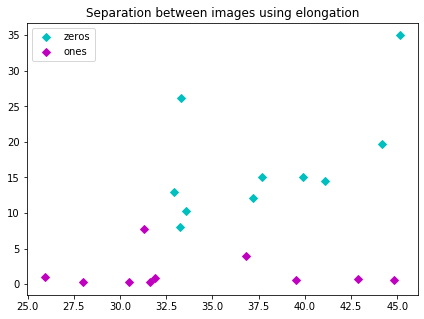

In [33]:
zero_vals = np.array(zero_vals)
one_vals = np.array(one_vals)
plot_2D(zero_vals[:,0],zero_vals[:,1],one_vals[:,0],one_vals[:,1],
        "Separation between images using elongation",labels=['zeros', 'ones'])

### A.6 Histogram of Oriented Gradients

Histogram of Oriented Gradients constructs a descriptor through the distribution of the direction of gradients, taking into account their magnitude. Let us see how useful such a feature descriptor can be.

In [34]:
def get_hog(im, display_hog=False):

    # get gradients
    gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)

    # get gradients' magnitude and (unsigned) angle
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    angle = angle % 180 

    # get histogram array
    hog = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    # angle decides bucket(s), mag decides value added
    for i in range(len(mag)):
        for j in range(len(mag[0])):
            if angle[i][j] >= 20 and angle[i][j] < 40:
                if angle[i][j] == 20:
                    hog[1] += mag[i][j]
                else:
                    # buckets 1 and 2 
                    split = (angle[i][j] - 20)/20
                    hog[1] += (1-split)*mag[i][j]
                    hog[2] += split*mag[i][j]
            elif angle[i][j] >= 40 and angle[i][j] < 60:
                if angle[i][j] == 40:
                    hog[2] += mag[i][j]
                else:
                    # buckets 2 and 3 
                    split = (angle[i][j] - 40)/20
                    hog[2] += (1-split)*mag[i][j]
                    hog[3] += split*mag[i][j]
            elif angle[i][j] >= 60 and angle[i][j] < 80:
                if angle[i][j] == 60:
                    hog[3] += mag[i][j]
                else:
                    # buckets 3 and 4 
                    split = (angle[i][j] - 60)/20
                    hog[3] += (1-split)*mag[i][j]
                    hog[4] += split*mag[i][j]
            elif angle[i][j] >= 80 and angle[i][j] < 100:
                if angle[i][j] == 80:
                    hog[4] += mag[i][j]
                else:
                    # buckets 4 and 5 
                    split = (angle[i][j] - 80)/20
                    hog[4] += (1-split)*mag[i][j]
                    hog[5] += split*mag[i][j]
            elif angle[i][j] >= 100 and angle[i][j] < 120:
                if angle[i][j] == 100:
                    hog[5] += mag[i][j]
                else:
                    # buckets 5 and 6 
                    split = (angle[i][j] - 100)/20
                    hog[5] += (1-split)*mag[i][j]
                    hog[6] += split*mag[i][j]
            elif angle[i][j] >= 120 and angle[i][j] < 140:
                if angle[i][j] == 120:
                    hog[6] += mag[i][j]
                else:
                    # buckets 6 and 7 
                    split = (angle[i][j] - 120)/20
                    hog[6] += (1-split)*mag[i][j]
                    hog[7] += split*mag[i][j]
            elif angle[i][j] >= 140 and angle[i][j] < 160:
                if angle[i][j] == 140:
                    hog[7] += mag[i][j]
                else:
                    # buckets 7 and 8 
                    split = (angle[i][j] - 140)/20
                    hog[7] += (1-split)*mag[i][j]
                    hog[8] += split*mag[i][j]
            elif angle[i][j] >= 160 and angle[i][j] < 180:
                if angle[i][j] == 160:
                    hog[8] += mag[i][j]
                else:
                    # buckets 8 and 0 
                    split = (angle[i][j] - 160)/20
                    hog[8] += (1-split)*mag[i][j]
                    hog[0] += split*mag[i][j]
            elif angle[i][j] >= 0:
                if angle[i][j] == 0:
                    hog[0] += mag[i][j]
                else:
                    # buckets 0 and 1 
                    split = angle[i][j]/20
                    hog[0] += (1-split)*mag[i][j]
                    hog[1] += split*mag[i][j]

    if display_hog:
        plt.bar([0,20,40,60,80,100,120,140,160], hog, width=10, tick_label=[0,20,40,60,80,100,120,140,160])
        plt.show()
        
    return hog

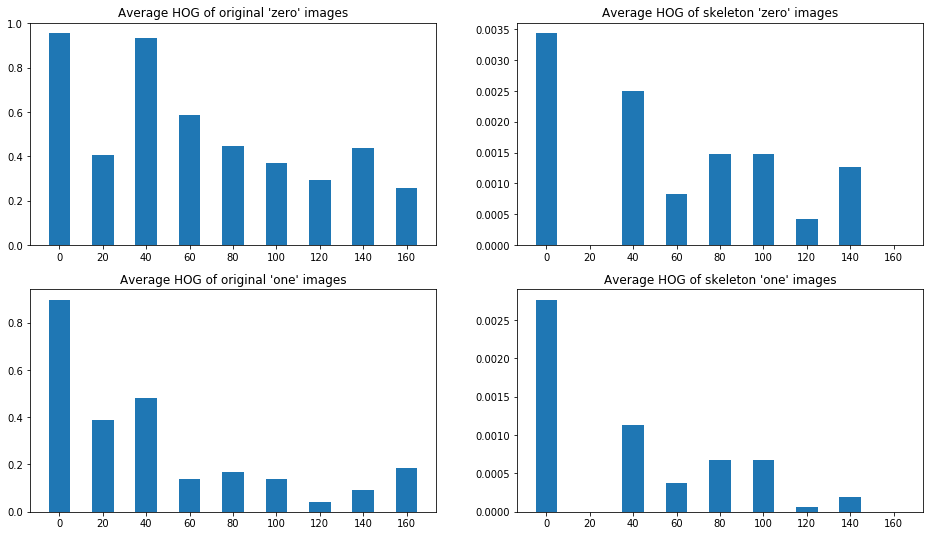

In [35]:
# get histogram of gradient orientations for non-modified and skeletonized zeros
zeros_hog_avg = get_hog(zeros_im[0])
for i in range(1,10):
    zeros_hog_avg = np.add(zeros_hog_avg, get_hog(zeros_im[i]))
zeros_hog_avg /= 100000

zeros_ske_hog_avg = get_hog(np.float32(skeletonize(binary_zeros_im[0])))
for i in range(1,10):
    zeros_ske_hog_avg = np.add(zeros_ske_hog_avg, get_hog(np.float32(skeletonize(binary_zeros_im[i]))))
zeros_ske_hog_avg /= 100000

# get histogram of gradient orientations for non-modified and skeletonized ones
ones_hog_avg = get_hog(ones_im[0])
for i in range(1,10):
    ones_hog_avg = np.add(ones_hog_avg, get_hog(ones_im[i]))
ones_hog_avg /= 100000

ones_ske_hog_avg = get_hog(np.float32(skeletonize(binary_ones_im[0])))
for i in range(1,10):
    ones_ske_hog_avg = np.add(ones_ske_hog_avg, get_hog(np.float32(skeletonize(binary_ones_im[i]))))
ones_ske_hog_avg /= 100000

# plot histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))

axes[0][0].set_title('Average HOG of original \'zero\' images')
axes[0][0].bar([0,20,40,60,80,100,120,140,160], 
               zeros_hog_avg, width=10, 
               tick_label=[0,20,40,60,80,100,120,140,160])

axes[0][1].set_title('Average HOG of skeleton \'zero\' images')
axes[0][1].bar([0,20,40,60,80,100,120,140,160], 
               zeros_ske_hog_avg, width=10, 
               tick_label=[0,20,40,60,80,100,120,140,160])

axes[1][0].set_title('Average HOG of original \'one\' images')
axes[1][0].bar([0,20,40,60,80,100,120,140,160], 
               ones_hog_avg, width=10, 
               tick_label=[0,20,40,60,80,100,120,140,160])

axes[1][1].set_title('Average HOG of skeleton \'one\' images')
axes[1][1].bar([0,20,40,60,80,100,120,140,160], 
               ones_ske_hog_avg, width=10, 
               tick_label=[0,20,40,60,80,100,120,140,160])

plt.show()

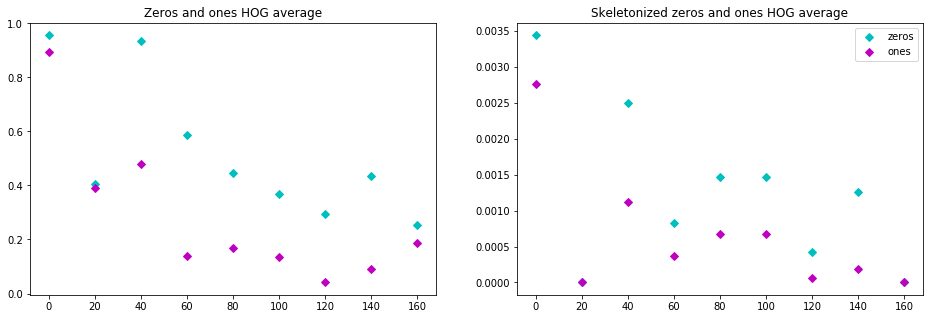

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_2D([0,20,40,60,80,100,120,140,160], zeros_hog_avg, 
        [0,20,40,60,80,100,120,140,160], ones_hog_avg, 
        'Zeros and ones HOG average', ['zeros', 'ones'], 
        axes[0])
plot_2D([0,20,40,60,80,100,120,140,160], zeros_ske_hog_avg, 
        [0,20,40,60,80,100,120,140,160], ones_ske_hog_avg, 
        'Skeletonized zeros and ones HOG average', ['zeros', 'ones'], 
        axes[1])
plt.legend()
plt.show()

We can see some difference in the average HoG values of ones and zeros, but not enough to make them linearly separable.

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

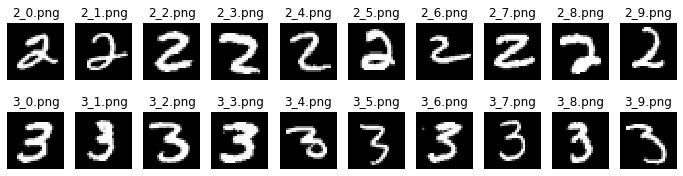

In [37]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

## 2.2 Additional method(s)

### 2.2.1 Fourier descriptors

#### Classic implementation

By applying the classical approach already described in section 1.2.1, it is impossible to separate the twos and threes by using only the first two descriptors.

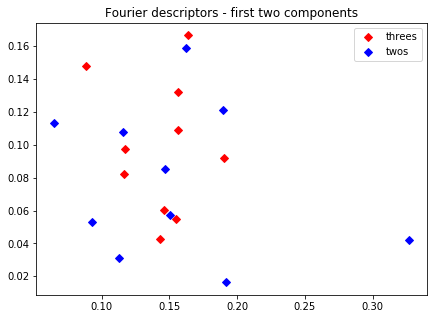

In [38]:
def find_contour(original_im,threshold,name,flag):
    retval, th = cv2.threshold(original_im, threshold, 255, cv2.THRESH_BINARY_INV)
    edge_rob = skimage.filters.roberts(th)
    indr=np.where(edge_rob!=0)[0]
    indc=np.where(edge_rob!=0)[1]
    
    im_edges = cv2.cvtColor(original_im, cv2.COLOR_GRAY2RGB)
    im_edges[edge_rob!=0,0]=254
    im_edges[edge_rob!=0,1]=127
    im_edges[edge_rob!=0,2]=156
    
    if flag==1:
        fig, axs = plt.subplots(1, 3, figsize=(17,12))
        axs[0].imshow(original_im, cmap = 'gray')
        axs[0].set_title('Original image - '+ name)
        axs[0].axis('off')

        axs[1].imshow(th, cmap = 'gray')
        axs[1].set_title("Thresholded - "+ name)
        axs[1].axis('off')


        axs[2].imshow(im_edges)
        axs[2].set_title("Detected edges - "+ name)
        axs[2].axis('off')

    ind_r=np.where(edge_rob!=0)[0]
    ind_c=np.where(edge_rob!=0)[1]
    return ind_r, ind_c

fourier_coeffs, labels = plotFourierDescriptors(twos_im, threes_im, "twos", "threes")

#### Implementation leveraging morphological skeletons

Since the first try proved inconclusive, we will see whether using instead the skeletons obtained with mathematical morphology can lead us to better results.

In [39]:
# we first need to convert each image into a binary mask
binary_twos_im = twos_im > 192
binary_threes_im = threes_im > 192

two_skeletons = np.zeros(twos_im.shape)
three_skeletons = np.zeros(threes_im.shape)

# then, we can obtain each image's skeleton
for i in range(len(binary_twos_im)):
    # perform skeletonization
    tw_im = binary_twos_im[i]
    tw_skeleton = skeletonize(tw_im)
    two_skeletons[i] = tw_skeleton
    th_im = binary_threes_im[i]
    th_skeleton = skeletonize(th_im)
    three_skeletons[i] = th_skeleton

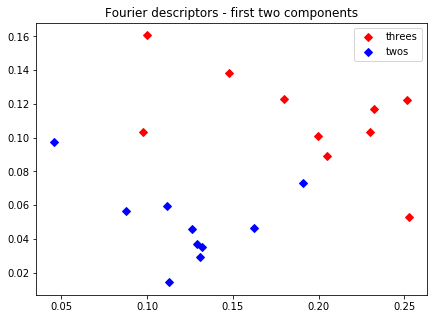

In [40]:
fourier_sk, labels_sk = fourierizeSkeletons(two_skeletons,three_skeletons, "twos", "threes")

We can observe a better separation, though not wholly successful.

In [41]:
#check if any Fourier descriptor features are linearly separable
ft_1 = fourier_sk[0:10,:]
ft_2 = fourier_sk[10:20,:]
check_discriminatory_properties(ft_1,ft_2)

KS1, feature number: 0 results 0.6
p value, feature number: 0 results 0.05244755244755244
KS1, feature number: 1 results 0.8
p value, feature number: 1 results 0.002056766762649115
KS1, feature number: 2 results 0.4
p value, feature number: 2 results 0.41752365281777043
KS1, feature number: 3 results 0.7
p value, feature number: 3 results 0.012340600575894691
KS1, feature number: 4 results 0.4
p value, feature number: 4 results 0.41752365281777043
KS1, feature number: 5 results 0.5
p value, feature number: 5 results 0.16782134274394334
KS1, feature number: 6 results 0.5
p value, feature number: 6 results 0.16782134274394334
KS1, feature number: 7 results 0.5
p value, feature number: 7 results 0.16782134274394334
KS1, feature number: 8 results 0.2
p value, feature number: 8 results 0.9944575548290717
KS1, feature number: 9 results 0.6
p value, feature number: 9 results 0.05244755244755244


#### Application of PCA

Similarly to section 1.2.3, let us compare these with the two features obtained via PCA on all descriptors, instead of simply the first two descriptors of the Fourier.

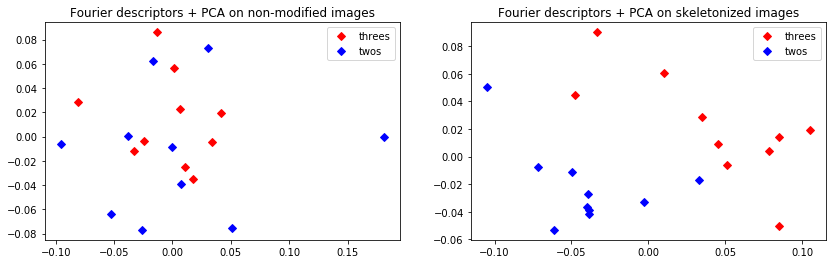

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fourierPCA(fourier_coeffs, labels, axes[0], "twos", "threes")
fourierPCA(fourier_sk, labels_sk, axes[1], "twos", "threes")
axes[0].set_title('Fourier descriptors + PCA on non-modified images')
axes[1].set_title('Fourier descriptors + PCA on skeletonized images')
plt.show()

We can conlude once again that the resutls obtained by PCA and the ones that emerge from simply using the first two descriptors obtained are very similar. As such, this approach still remains somewhat inconclusive on the topic of successful separation of the categories.

### 2.2.2 PCA using relative Freeman coding values

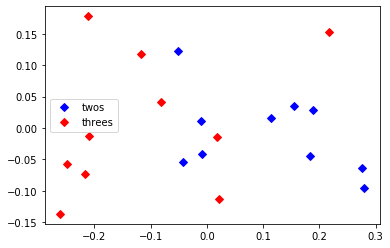

In [43]:
fig, ax = plt.subplots()

# PCA with relative freeman values
norm_counts, labels = compareRelativeFreemanValuesSkeleton(two_skeletons,three_skeletons)
fourierPCA(norm_counts, labels, ax, first_label="twos", second_label="threes")

Simply applying PCA to the relative Freeman coding values does not result in a linearly separable plot. Let us investigate, however, whether there are other features we can leverage to still obtain such a result.

In [44]:
#Check the K-S values of the relative Freeman coding value counts
ft_1 = norm_counts[0:10,:]
ft_2 = norm_counts[10:20,:]
check_discriminatory_properties(ft_1,ft_2)

KS1, feature number: 0 results 0.6
p value, feature number: 0 results 0.05244755244755244
KS1, feature number: 1 results 0.3
p value, feature number: 1 results 0.7869297884777761
KS1, feature number: 2 results 0.4
p value, feature number: 2 results 0.41752365281777043
KS1, feature number: 3 results 0.4
p value, feature number: 3 results 0.41752365281777043
KS1, feature number: 4 results 0.8
p value, feature number: 4 results 0.002056766762649115
KS1, feature number: 5 results 0.6
p value, feature number: 5 results 0.05244755244755244
KS1, feature number: 6 results 0.5
p value, feature number: 6 results 0.16782134274394334
KS1, feature number: 7 results 0.7
p value, feature number: 7 results 0.012340600575894691


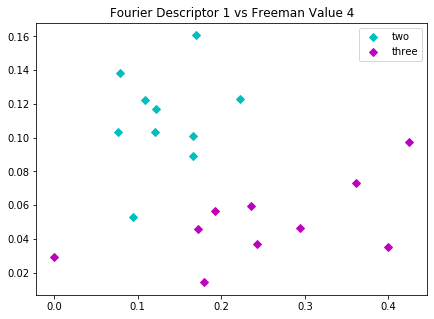

In [45]:
# plot 2 vs 3 using the first Fourier coefficient vs the 4th relative Freeman coefficient
plot_2D(norm_counts[0:10,4], fourier_sk[0:10,1],
        norm_counts[10:20,4], fourier_sk[10:20,1],
        'Fourier Descriptor 1 vs Freeman Value 4', ['two','three'])

And indeed, we can observe that by leveraging two of the coefficients with highest linear separability (one Fourier descriptor and one relative Freeman count value), we can obtain a 2D, linearly separable plot!

### 2.2.3 Hu Moments

We will now compute the Hu moments for images of both `twos` and `threes`. 

KS1, feature number: 0 results 0.5
p value, feature number: 0 results 0.16782134274394334
KS1, feature number: 1 results 0.7
p value, feature number: 1 results 0.012340600575894691
KS1, feature number: 2 results 0.2
p value, feature number: 2 results 0.9944575548290717
KS1, feature number: 3 results 0.6
p value, feature number: 3 results 0.05244755244755244
KS1, feature number: 4 results 0.3
p value, feature number: 4 results 0.7869297884777761
KS1, feature number: 5 results 0.3
p value, feature number: 5 results 0.7869297884777761
KS1, feature number: 6 results 0.6
p value, feature number: 6 results 0.05244755244755244


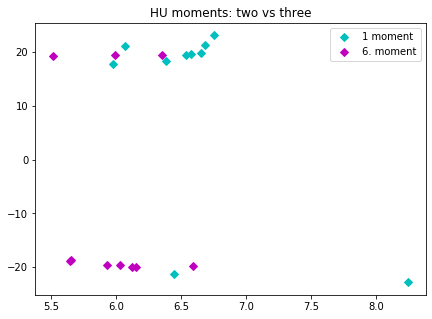

In [46]:
HM1,HM2 = compute_HU_moments(twos_im,threes_im)

check_discriminatory_properties(HM1,HM2)

title_='HU moments: two vs three'
labels=['1 moment','6. moment']
plot_2D(HM1[:,1],HM1[:,6],HM2[:,1],HM2[:,6],title_,labels)

Results are significantly worse when compared to the simpler case of images of `zeros` versus `ones`. 
This is both shown via the KS test result and visualized in one 2D plot of the two features with the lowest p-values.

### 2.2.4 Average Image Convolution

As in section 1.3.3, we first start by deskewing all images, and then finding the mean image for each of the categories.

(10, 28, 28)


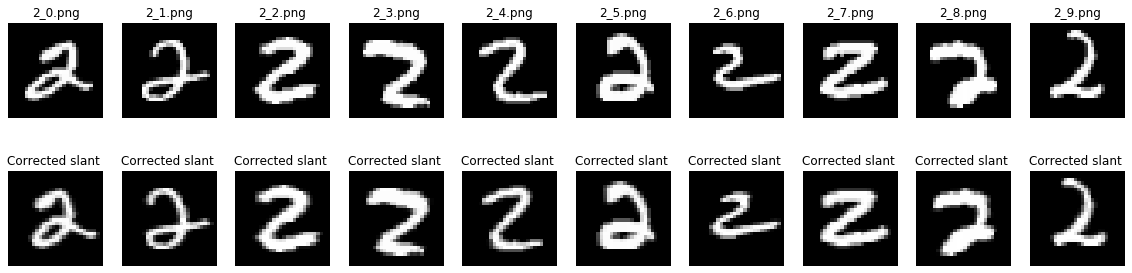

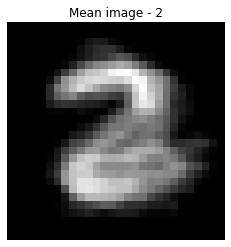

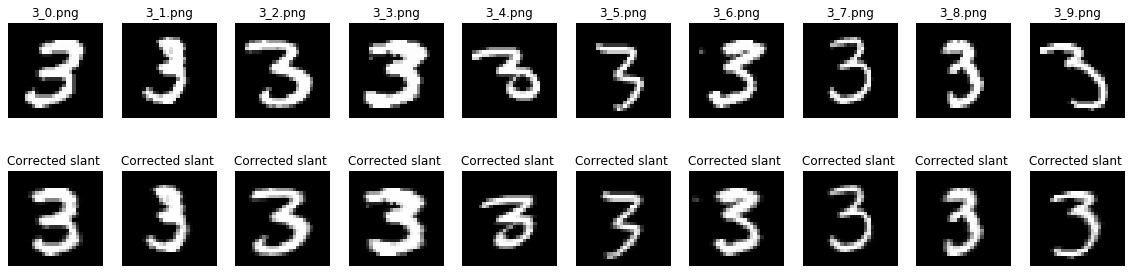

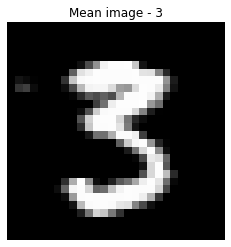

In [47]:
twos_imc=twos_im.copy()
threes_imc=threes_im.copy()

i=0
fig, axs = plt.subplots(2, 10, figsize=(20,5))
for im, on in zip(twos_im, twos_names):
    res=deskew(im)
    retval, th = cv2.threshold(res, threshold, 255, cv2.THRESH_BINARY_INV)
    axs[0,i].imshow(im, cmap = 'gray')
    axs[0,i].set_title(on)
    axs[0,i].axis('off')
    axs[1,i].imshow(res, cmap = 'gray')
    axs[1,i].set_title('Corrected slant ')
    axs[1,i].axis('off')
    twos_imc[i]=res
    i+=1
print(np.shape(twos_imc))
mean_twos=np.mean(twos_imc[:,:, :],axis=0)
plt.figure()
plt.imshow(mean_twos,cmap='gray')
plt.title('Mean image - 2')
plt.axis('off')
plt.show()
    
i=0
fig, axs = plt.subplots(2, 10, figsize=(20,5))
for im, on in zip(threes_im, threes_names):
    res=deskew(im)
    axs[0,i].imshow(im, cmap = 'gray')
    axs[0,i].set_title(on)
    axs[0,i].axis('off')
    axs[1,i].imshow(res, cmap = 'gray')
    axs[1,i].set_title('Corrected slant ')
    axs[1,i].axis('off')
    threes_imc[i]=res
    i+=1
    
mean_threes=np.mean(threes_imc[[6],:,:],axis=0)
plt.figure()
plt.imshow(mean_threes,cmap='gray')
plt.title('Mean image - 3')
plt.axis('off')
plt.show()

The template for number 2 is blurred in the bottom part of the digit, which is reasonable since its shape  varies significally across all images.

Let us now find the convolution features. We plot the 2 features with the best performance according to the KS test. Some kind of grouping of the samples is noticeable, but dispite this, we can't find a linear separation through using only two features.

KS1, feature number: 0 results 0.9
p value, feature number: 0 results 0.00021650176448938054
KS1, feature number: 1 results 0.4
p value, feature number: 1 results 0.41752365281777043
KS1, feature number: 2 results 0.8
p value, feature number: 2 results 0.002056766762649115
KS1, feature number: 3 results 0.6
p value, feature number: 3 results 0.05244755244755244
KS1, feature number: 4 results 0.4
p value, feature number: 4 results 0.41752365281777043
KS1, feature number: 5 results 0.5
p value, feature number: 5 results 0.16782134274394334
KS1, feature number: 6 results 0.3
p value, feature number: 6 results 0.7869297884777761
KS1, feature number: 7 results 0.4
p value, feature number: 7 results 0.41752365281777043
KS1, feature number: 8 results 0.4
p value, feature number: 8 results 0.41752365281777043
KS1, feature number: 9 results 0.5
p value, feature number: 9 results 0.16782134274394334
KS1, feature number: 10 results 0.3
p value, feature number: 10 results 0.7869297884777761
KS1, f

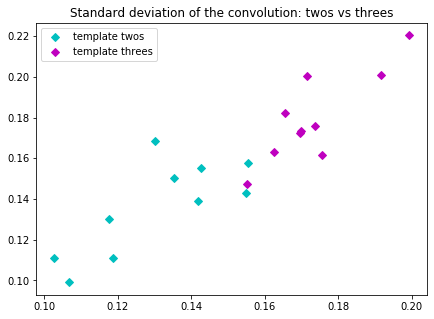

In [48]:
f1=np.zeros((10,14))
i=0
for im, on in zip(twos_imc, zeros_names):
    fi=conv_features(mean_twos,mean_threes,im,0,0)
    f1[i,:]=fi
    i+=1
    

f2=np.zeros((10,14))
i=0
for im, on in zip(threes_imc, ones_names):
    fi=conv_features(mean_twos,mean_threes,im,0,0)
    f2[i,:]=fi
    i+=1


    
check_discriminatory_properties(f1,f2)

title_='Standard deviation of the convolution: twos vs threes'
labels=['template twos','template threes']
plot_2D(f1[:,0],f1[:,2],f2[:,0],f2[:,2],title_,labels)

#### Half-image convolutions

Since we were unable to find a linear separation above, we will change our approach. While using the same method, we will now split images into their lower and upper halfs. Intuitively, the bottom part could prove useful in the differentiation between `twos` and `threes`.

(12, 28)


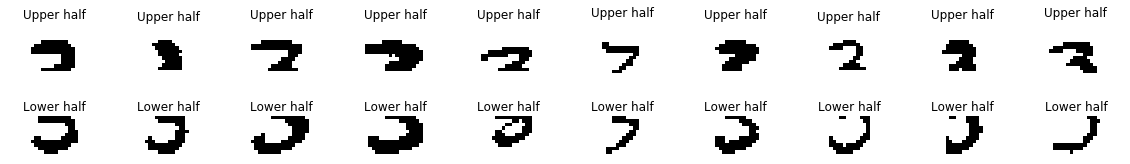

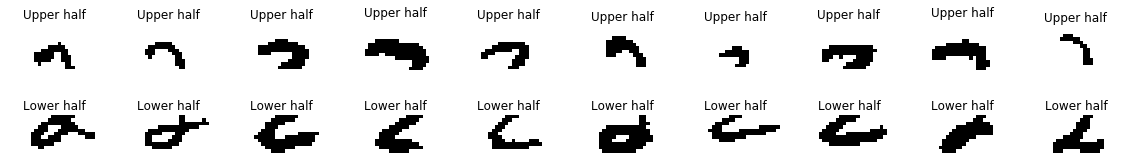

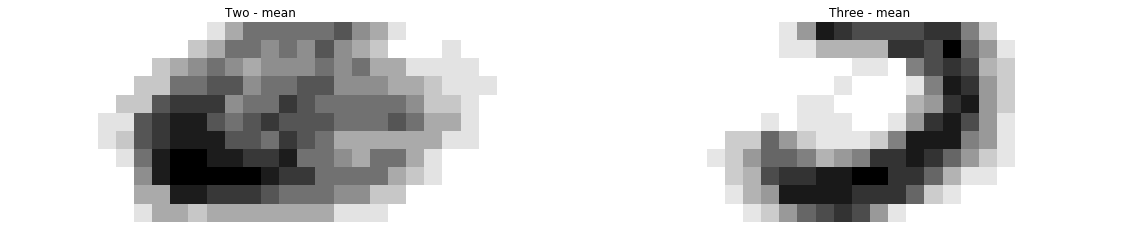

In [49]:
fig,axs=plt.subplots(2,10,figsize=(20,3))
i=0

three_2half=[]
for im in threes_imc:

    threshold=100
    retval, th = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY_INV)

    rows= np.where(th==0)[0]

    l1=min(rows)

    l2=max(rows)
    s1=th[l1:l2,:]
    
    half=int((l2+l1)/2)

    s2=th[0:half]
    s3=th[half:half+12]
    three_2half.append(s3)
    
    axs[0,i].imshow(s2, cmap='gray')
    axs[0,i].set_title('Upper half')
    axs[0,i].axis('off')
    axs[1,i].imshow(s3, cmap='gray')
    axs[1,i].set_title('Lower half')
    axs[1,i].axis('off')
    i+=1

three_2hm=np.mean(three_2half,axis=0)    

#twos
two_2half=[]
fig,axs=plt.subplots(2,10,figsize=(20,3))
i=0
for im in twos_imc:

    threshold=100
    retval, th = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY_INV)

    rows= np.where(th==0)[0]

    l1=min(rows)

    l2=max(rows)
    s1=th[l1:l2,:]
    
    half=int((l2+l1)/2)

    s2=th[0:half]
    s3=th[half:half+12]
    two_2half.append(s3)
    
    axs[0,i].imshow(s2, cmap='gray')
    axs[0,i].set_title('Upper half')
    axs[0,i].axis('off')
    axs[1,i].imshow(s3, cmap='gray')
    axs[1,i].set_title('Lower half')
    axs[1,i].axis('off')
    i+=1

print(np.shape(two_2half[4]))
two_2hm=np.mean(two_2half,axis=0)#two_2half[4]

fig,axs = plt.subplots(1,2,figsize=(20,7))
axs[0].imshow(two_2hm,cmap='gray')
axs[0].set_title('Two - mean')
axs[0].axis('off')
axs[1].imshow(three_2hm,cmap='gray')
axs[1].set_title('Three - mean')
axs[1].axis('off')
plt.show()

Now, let's run convolution codes on second half of the numbers:

KS1, feature number: 0 results 0.5
p value, feature number: 0 results 0.16782134274394334
KS1, feature number: 1 results 0.7
p value, feature number: 1 results 0.012340600575894691
KS1, feature number: 2 results 0.6
p value, feature number: 2 results 0.05244755244755244
KS1, feature number: 3 results 0.5
p value, feature number: 3 results 0.16782134274394334
KS1, feature number: 4 results 0.7
p value, feature number: 4 results 0.012340600575894691
KS1, feature number: 5 results 0.3
p value, feature number: 5 results 0.7869297884777761
KS1, feature number: 6 results 0.7
p value, feature number: 6 results 0.012340600575894691
KS1, feature number: 7 results 0.9
p value, feature number: 7 results 0.00021650176448938054
KS1, feature number: 8 results 0.3
p value, feature number: 8 results 0.7869297884777761
KS1, feature number: 9 results 0.4
p value, feature number: 9 results 0.41752365281777043
KS1, feature number: 10 results 0.7
p value, feature number: 10 results 0.012340600575894691
KS1

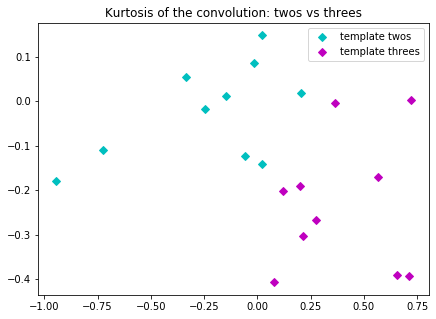

In [50]:
f1=np.zeros((10,14))
i=0
for im, on in zip(twos_imc, zeros_names):
    fi=conv_features(two_2hm,three_2hm,im,0,0)
    f1[i,:]=fi
    i+=1
    

f2=np.zeros((10,14))
i=0
for im, on in zip(threes_imc, ones_names):
    fi=conv_features(two_2hm,three_2hm,im,0,0)
    f2[i,:]=fi
    i+=1

    
check_discriminatory_properties(f1,f2)

title_='Kurtosis of the convolution: twos vs threes'
labels=['template twos','template threes']
plot_2D(f1[:,7],f1[:,10],f2[:,7],f2[:,10],title_,labels)

Above, we present two plots, containing the most promising convolutional features according to the KS test. Finally, we are able to achieve a linear separation between `twos` and `threes`.

Next, we will assume that we only have one object per image, which is the digit, and we are always able to cut it easily with thresholding. This is both an assumption and a limitation, as the threshold boundaries may be difficult to discern. Let's try to extract the rectangle that contains only the digit, without the black background. We then resize the template to the corresponding dimensions of the object. Then we perform convoution. Additionaly, we choose only one image that sems to be the best representative of the class as template (as previously computed templates were blured).

KS1, feature number: 0 results 0.4
p value, feature number: 0 results 0.41752365281777043
KS1, feature number: 1 results 0.7
p value, feature number: 1 results 0.012340600575894691
KS1, feature number: 2 results 0.5
p value, feature number: 2 results 0.16782134274394334
KS1, feature number: 3 results 0.9
p value, feature number: 3 results 0.00021650176448938054
KS1, feature number: 4 results 0.7
p value, feature number: 4 results 0.012340600575894691
KS1, feature number: 5 results 0.2
p value, feature number: 5 results 0.9944575548290717
KS1, feature number: 6 results 0.6
p value, feature number: 6 results 0.05244755244755244
KS1, feature number: 7 results 0.5
p value, feature number: 7 results 0.16782134274394334
KS1, feature number: 8 results 0.7
p value, feature number: 8 results 0.012340600575894691
KS1, feature number: 9 results 0.3
p value, feature number: 9 results 0.7869297884777761
KS1, feature number: 10 results 0.6
p value, feature number: 10 results 0.05244755244755244
KS1,

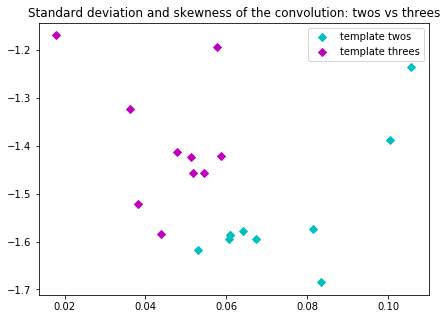

In [51]:
threshold=100
retval, th = cv2.threshold(twos_imc[2], threshold, 255, cv2.THRESH_BINARY_INV)
rows= np.where(th==0)[0]
l1=min(rows)
l2=max(rows)
temp2=th[l1:l2,:]

retval, th = cv2.threshold(threes_imc[0], threshold, 255, cv2.THRESH_BINARY_INV)
rows= np.where(th==0)[0]
l1=min(rows)
l2=max(rows)
temp3=th[l1:l2,:]



f1=np.zeros((10,14))
i=0
for im, on in zip(twos_imc, zeros_names):
    threshold=100
    retval, th = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY_INV)
    rows= np.where(th==0)[0]
    l1=min(rows)
    l2=max(rows)
    s1=th[l1:l2,:]
    temp2_res =  imutils.resize( temp2, width=(l2-l1))
    temp3_res =  imutils.resize( temp3, width=(l2-l1))
    fi=conv_features(temp2_res,temp3_res,s1,0,0)
    f1[i,:]=fi
    i+=1
    

f2=np.zeros((10,14))
i=0
for im, on in zip(threes_imc, ones_names):
    threshold=100
    retval, th = cv2.threshold(im, threshold, 255, cv2.THRESH_BINARY_INV)
    rows= np.where(th==0)[0]
    l1=min(rows)
    l2=max(rows)
    s1=th[l1:l2,:]
    temp2_res =  imutils.resize( temp2, width=(l2-l1))
    temp3_res =  imutils.resize( temp3, width=(l2-l1))
    fi=conv_features(temp2_res,temp3_res,s1,0,0)
    f2[i,:]=fi
    i+=1

check_discriminatory_properties(f1,f2)

title_='Standard deviation and skewness of the convolution: twos vs threes'
labels=['template twos','template threes']
plot_2D(f1[:,3],f1[:,8],f2[:,3],f2[:,8],title_,labels)

Finally, using this technique of resizing the images to the template image and extracting convolutional features this way, we are able to achieve a linear separation between the `twos` and `threes`.

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

## B. Appendix for Part 2

Similarly to appendix A, in this section we present several other methods that were attempted for the separation of `twos` and `threes`, but that ultimately did not reveal the same level of potential as the methods presented in section 2.2.

### B.1 Mathematical Morphology - Skeletons

Similarly to section A.2, we obtain the skeletons of each shape. These are used in other methods.

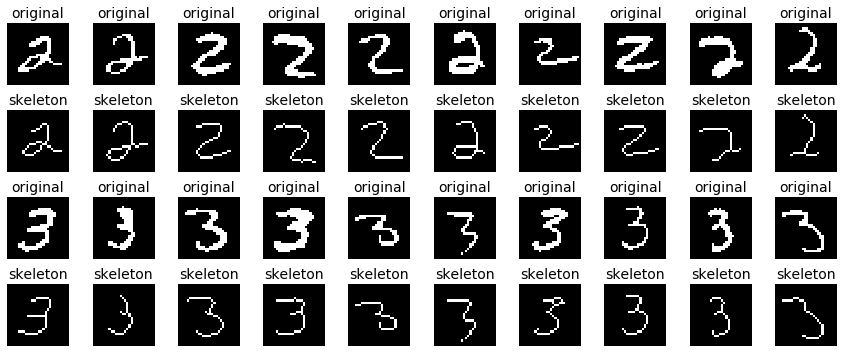

In [52]:
# we first need to convert each image into a binary mask
binary_twos_im = twos_im > 192
binary_threes_im = threes_im > 192

fig, axes = plt.subplots(nrows=4, ncols=len(binary_twos_im), figsize=(12, 5), sharex=True, sharey=True)

# then, we can obtain each image's skeleton
for i in range(len(binary_twos_im)):
    # perform skeletonization
    tw_im = binary_twos_im[i]
    tw_skeleton = skeletonize(tw_im)
    th_im = binary_threes_im[i]
    th_skeleton = skeletonize(th_im)

    # display results
    axes[0][i].imshow(tw_im, cmap=plt.cm.gray)
    axes[0][i].axis('off')
    axes[0][i].set_title('original', fontsize=14)
    axes[1][i].imshow(tw_skeleton, cmap=plt.cm.gray)
    axes[1][i].axis('off')
    axes[1][i].set_title('skeleton', fontsize=14)
    axes[2][i].imshow(th_im, cmap=plt.cm.gray)
    axes[2][i].axis('off')
    axes[2][i].set_title('original', fontsize=14)
    axes[3][i].imshow(th_skeleton, cmap=plt.cm.gray)
    axes[3][i].axis('off')
    axes[3][i].set_title('skeleton', fontsize=14)

fig.tight_layout()
plt.show()

### B.2 Major and minor axis, and eccentricity

Once again, we apply the same methodology used in sections B.3 and B.4, and evaluate the results.

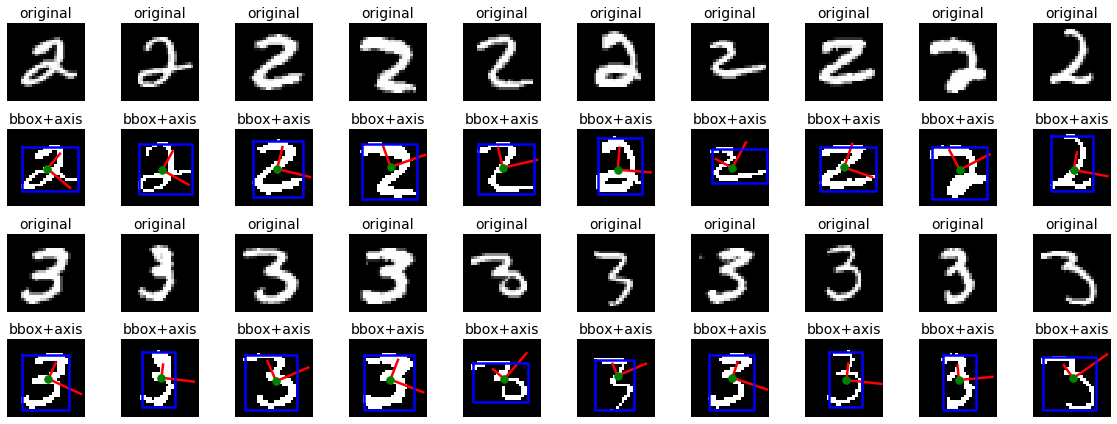

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=len(binary_twos_im), figsize=(16, 6), sharex=True, sharey=True)
    
for i in range(len(binary_twos_im)):
    # perform skeletonization
    tw_im = binary_twos_im[i]
    th_im = binary_threes_im[i]
    
    tw_label_img = label(tw_im)
    tw_regions = regionprops(tw_label_img)
    th_label_img = label(th_im)
    th_regions = regionprops(th_label_img)

    axes[1][i].imshow(tw_im, cmap=plt.cm.gray)
    axes[1][i].axis('off')
    axes[1][i].set_title('bbox+axis', fontsize=14)
    axes[3][i].imshow(th_im, cmap=plt.cm.gray)
    axes[3][i].axis('off')
    axes[3][i].set_title('bbox+axis', fontsize=14)
    
    for props in [tw_regions[0]]:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

        axes[1][i].plot((x0, x1), (y0, y1), '-r', linewidth=2.5) # major axis
        axes[1][i].plot((x0, x2), (y0, y2), '-r', linewidth=2.5) # minor axis
        axes[1][i].plot(x0, y0, '.g', markersize=15) # center

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        axes[1][i].plot(bx, by, '-b', linewidth=2.5)  # bounding box
        
    for props in [th_regions[0]]:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length

        axes[3][i].plot((x0, x1), (y0, y1), '-r', linewidth=2.5) # major axis
        axes[3][i].plot((x0, x2), (y0, y2), '-r', linewidth=2.5) # minor axis
        axes[3][i].plot(x0, y0, '.g', markersize=15) # center

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        axes[3][i].plot(bx, by, '-b', linewidth=2.5) # bounding box

    
    # display original images
    axes[0][i].imshow(twos_im[i], cmap=plt.cm.gray)
    axes[0][i].axis('off')
    axes[0][i].set_title('original', fontsize=14)
    axes[2][i].imshow(threes_im[i], cmap=plt.cm.gray)
    axes[2][i].axis('off')
    axes[2][i].set_title('original', fontsize=14)

fig.tight_layout()
plt.show()

In [54]:
print('\033[1mFor two images:\033[0m')
two_ratio_tops = 0
two_ratio_bots = 0
two_ratios = []
for i in range(len(binary_twos_im)):
    tw_im = binary_twos_im[i]
    tw_label_img = label(tw_im)
    tw_regions = regionprops(tw_label_img)
    
    for props in [tw_regions[0]]:
        two_ratio_tops += props.minor_axis_length
        two_ratio_bots += props.major_axis_length
        ratio = props.minor_axis_length/props.major_axis_length
        two_ratios.append(ratio)
        print(f'\t\tratio: {ratio}')
print(f'\033[1m\taverage ratio: {two_ratio_tops/two_ratio_bots}\033[0m')

print('\n\033[1mFor three images:\033[0m')
three_ratio_tops = 0
three_ratio_bots = 0
three_ratios = []
for i in range(len(binary_threes_im)):
    th_im = binary_threes_im[i]
    th_label_img = label(th_im)
    th_regions = regionprops(th_label_img)
    
    for props in [th_regions[0]]:
        three_ratio_tops += props.minor_axis_length
        three_ratio_bots += props.major_axis_length
        ratio = props.minor_axis_length/props.major_axis_length
        three_ratios.append(ratio)
        print(f'\t\tratio: {ratio}')
print(f'\033[1m\taverage ratio: {three_ratio_tops/three_ratio_bots}\033[0m')

For two images:
		ratio: 0.6536258256539931
		ratio: 0.7081857053925071
		ratio: 0.6625255907352701
		ratio: 0.6218703961327978
		ratio: 0.5856313163889785
		ratio: 0.6711767957822251
		ratio: 0.6461730594509597
		ratio: 0.8425918091858458
		ratio: 0.6579689947827096
		ratio: 0.5229905939420302
	average ratio: 0.6537000340871717

For three images:
		ratio: 0.49300782499777157
		ratio: 0.408954202704606
		ratio: 0.6282430968554368
		ratio: 0.5973807262195362
		ratio: 0.43886748568796863
		ratio: 0.4187637280579223
		ratio: 0.4517488561212723
		ratio: 0.47700206784233584
		ratio: 0.4271607192473995
		ratio: 0.39522557444797
	average ratio: 0.4736388560418355


Similarly to A.4, we can analyze these values visually below. We can see that this feature is not enough in order to be able to sucessfully separate the `twos` from the `threes`.

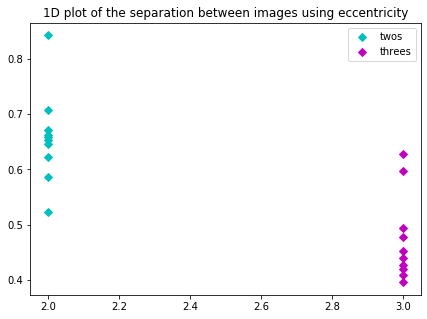

In [55]:
nb_images = len(two_ratios)
plot_2D([2]*nb_images,two_ratios,[3]*nb_images,three_ratios,
        "1D plot of the separation between images using eccentricity",labels=['twos', 'threes'])

### B.3 Elongation

In [56]:
import numpy as np
from skimage.measure import inertia_tensor_eigvals

print('\033[1mFor two images:\033[0m')
two_vals = []
for i in range(len(binary_twos_im)):
    tensors = inertia_tensor_eigvals(binary_twos_im[i])
    two_vals.append(tensors)
    print(f'\t\ttensors: {tensors}')    
print(f'\033[1m\taverage tensors: {np.average(two_vals, axis=0)}\033[0m')

print('\n\033[1mFor three images:\033[0m')
three_vals = []
for i in range(len(binary_threes_im)):
    tensors = inertia_tensor_eigvals(binary_threes_im[i])
    three_vals.append(tensors)
    print(f'\t\ttensors: {tensors}')
print(f'\033[1m\taverage tensors: {np.average(three_vals, axis=0)}\033[0m')

For two images:
		tensors: [29.081981685338842, 12.424599645418317]
		tensors: [29.590959156394774, 14.840664775229143]
		tensors: [37.26926601422595, 16.358977526957833]
		tensors: [43.95344835419844, 16.99780015947576]
		tensors: [40.01875863230798, 13.72499508571701]
		tensors: [35.35833731920291, 15.928163375103775]
		tensors: [27.27425059909381, 11.388080306213157]
		tensors: [28.502029703849526, 20.235328282338934]
		tensors: [36.67607495265025, 15.87792366208682]
		tensors: [38.13220160519616, 10.429887803552443]
	average tensors: [34.5857308  14.82064206]

For three images:
		tensors: [41.84842483703178, 10.171540690115599]
		tensors: [34.35287527764116, 5.745296467511185]
		tensors: [39.7662059627592, 15.69529952420924]
		tensors: [40.72613392443601, 14.533680144591795]
		tensors: [37.782840716340914, 7.277151567609704]
		tensors: [32.84966689014537, 6.178399238266783]
		tensors: [43.230807110444026, 8.82241467666883]
		tensors: [40.19560178125559, 9.145744372590572]
		tensors

As was the case in A.5, linear separation is almost feasible, but a several edge-cases from both categories prevent a clean split.

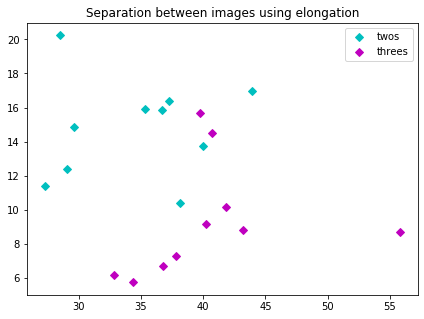

In [57]:
two_vals = np.array(two_vals)
three_vals = np.array(three_vals)
plot_2D(two_vals[:,0],two_vals[:,1],three_vals[:,0],three_vals[:,1],
        "Separation between images using elongation",labels=['twos', 'threes'])

### B.4 Histogram of Oriented Gradients

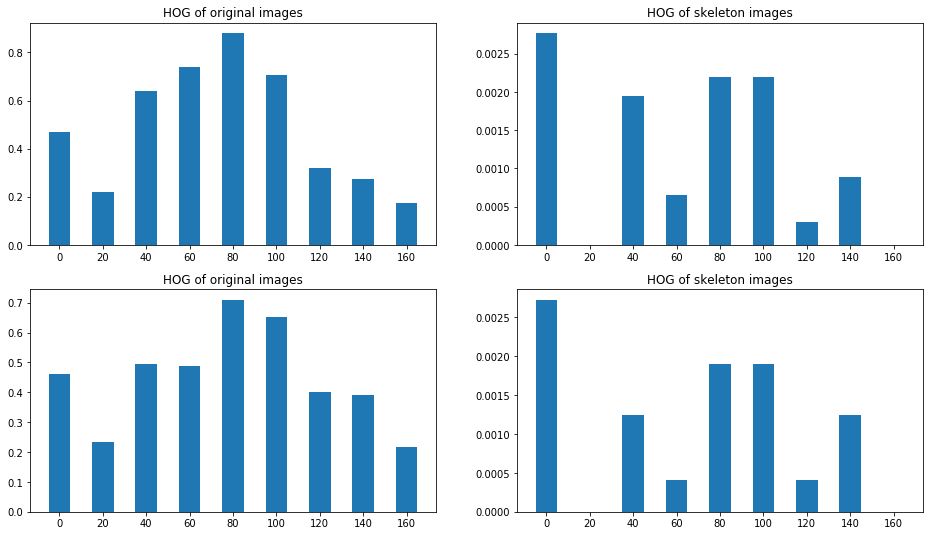

In [58]:
# get histogram of gradient orientations for non-modified and skeletonized zeros
twos_hog_avg = get_hog(twos_im[0])
for i in range(1,10):
    twos_hog_avg = np.add(twos_hog_avg, get_hog(twos_im[i]))
twos_hog_avg /= 100000

twos_ske_hog_avg = get_hog(np.float32(skeletonize(binary_twos_im[0])))
for i in range(1,10):
    twos_ske_hog_avg = np.add(twos_ske_hog_avg, get_hog(np.float32(skeletonize(binary_twos_im[i]))))
twos_ske_hog_avg /= 100000

threes_hog_avg = get_hog(threes_im[0])
for i in range(1,10):
    threes_hog_avg = np.add(threes_hog_avg, get_hog(threes_im[i]))
threes_hog_avg /= 100000

threes_ske_hog_avg = get_hog(np.float32(skeletonize(binary_threes_im[0])))
for i in range(1,10):
    threes_ske_hog_avg = np.add(threes_ske_hog_avg, get_hog(np.float32(skeletonize(binary_threes_im[i]))))
threes_ske_hog_avg /= 100000

# plot histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 9))

axes[0][0].set_title('HOG of original images')
axes[0][0].bar([0,20,40,60,80,100,120,140,160], 
               twos_hog_avg, width=10, 
               tick_label=[0,20,40,60,80,100,120,140,160])

axes[0][1].set_title('HOG of skeleton images')
axes[0][1].bar([0,20,40,60,80,100,120,140,160], 
               twos_ske_hog_avg, width=10, 
               tick_label=[0,20,40,60,80,100,120,140,160])

axes[1][0].set_title('HOG of original images')
axes[1][0].bar([0,20,40,60,80,100,120,140,160], 
               threes_hog_avg, width=10, 
               tick_label=[0,20,40,60,80,100,120,140,160])

axes[1][1].set_title('HOG of skeleton images')
axes[1][1].bar([0,20,40,60,80,100,120,140,160], 
               threes_ske_hog_avg, width=10, 
               tick_label=[0,20,40,60,80,100,120,140,160])

plt.show()

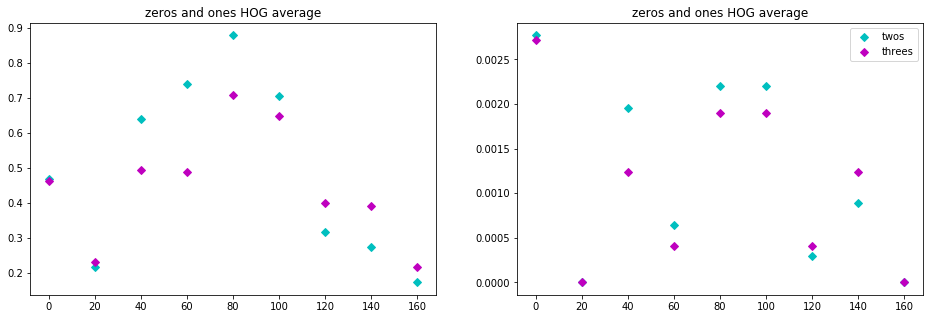

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_2D([0,20,40,60,80,100,120,140,160], 
        twos_hog_avg, [0,20,40,60,80,100,120,140,160], threes_hog_avg, 
        'zeros and ones HOG average', ['twos', 'threes'], axes[0])
plot_2D([0,20,40,60,80,100,120,140,160], twos_ske_hog_avg, 
        [0,20,40,60,80,100,120,140,160], threes_ske_hog_avg, 
        'zeros and ones HOG average', ['twos', 'threes'], axes[1])
plt.legend()
plt.show()

<img src="https://i.pinimg.com/originals/a6/36/fc/a636fc44b6502370617271d3088acd02.png" style="height:100px; overflow: hidden"/>

## 2.3 Conclusion

## Final Result: 0 vs 1 separation
The Fourier descriptors of the morphological skeletens of the digits achieved the largest separation between `ones` and `zeros`, as well as the highest degree of digit clustering.

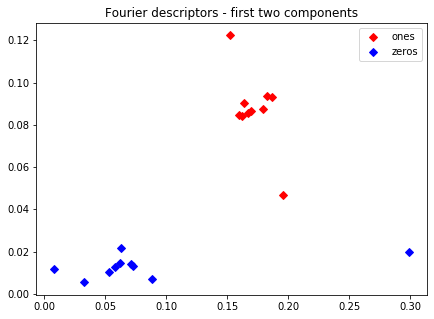

In [60]:
fourier_sk, labels_sk = fourierizeSkeletons(one_skeletons,zero_skeletons)

## Final Result: 2 vs 3 separation
Meanwhile for the `twos` and `threes`, selecting a representative digit as the template for convolution and rescaling it to fit each subsequent digit has produced the features with the best linear separability.

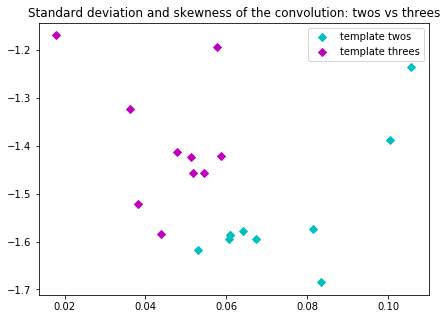

In [61]:
title_='Standard deviation and skewness of the convolution: twos vs threes'
labels=['template twos','template threes']
plot_2D(f1[:,3],f1[:,8],f2[:,3],f2[:,8],title_,labels)

## Separating all four classes
Now, we use several successful features that produced linear separation between two of the four classes and attempt to plot them for all four classes. The results show that it is extremely difficult to find only two features that separate and cluster all four classes.

In [62]:
norm_counts2, labels2 = compareRelativeFreemanValuesSkeleton(two_skeletons,three_skeletons)
labels2 += 2

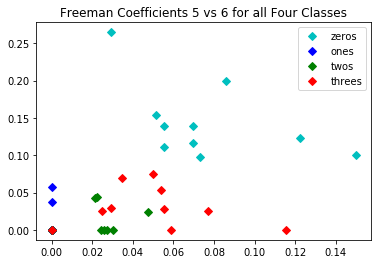

In [63]:
fig, ax = plt.subplots()
plt.title('Freeman Coefficients 5 vs 6 for all Four Classes')
norm_counts1, labels1 = compareRelativeFreemanValuesSkeleton(zero_skeletons,one_skeletons)
z_labeled,o_labeled,t_labeled,th_labeled = False, False, False, False
for norm, label in zip(norm_counts1, labels1):
    if label==0:
        plt.plot(norm[5],norm[6],'cD',label='zeros' if not z_labeled else None)
        z_labeled=True
    elif label==1:
        plt.plot(norm[5],norm[6],'bD',label='ones' if not o_labeled else None)
        o_labeled = True
for norm, label in zip(norm_counts2, labels2):
    if label==2:
        plt.plot(norm[5],norm[6],'gD', label='twos' if not t_labeled else None)
        t_labeled = True
    elif label==3:
        plt.plot(norm[5],norm[6],'rD', label='threes' if not th_labeled else None)
        th_labeled = True
plt.legend()
plt.show()

While the zero labels occupy their own space, there is significant overlap between the twos, threes, and ones. Now, let's try again with the fourier descriptors of the image skeletons, which were nearly linearly separable for `zeros` vs `ones` and `twos` vs `threes`. 

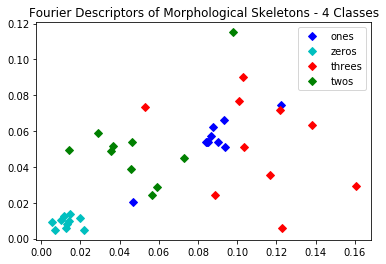

In [64]:
fourier_sk1, labels_sk1 = fourierizeSkeletons(one_skeletons,zero_skeletons, plot=False)
fourier_sk2, labels_sk2 = fourierizeSkeletons(two_skeletons,three_skeletons, "twos", "threes", plot=False)
labels_sk2 += 2

z_labeled,o_labeled,t_labeled,th_labeled = False, False, False, False
for norm, label in zip(fourier_sk1, labels_sk1):
    if label==0:
        plt.plot(norm[1],norm[2],'cD',label='zeros' if not z_labeled else None)
        z_labeled=True
    elif label==1:
        plt.plot(norm[1],norm[2],'bD',label='ones' if not o_labeled else None)
        o_labeled = True
for norm, label in zip(fourier_sk2, labels_sk2):
    if label==2:
        plt.plot(norm[1],norm[2],'gD', label='twos' if not t_labeled else None)
        t_labeled = True
    elif label==3:
        plt.plot(norm[1],norm[2],'rD', label='threes' if not th_labeled else None)
        th_labeled = True
plt.title('Fourier Descriptors of Morphological Skeletons - 4 Classes')
plt.legend()
plt.show()

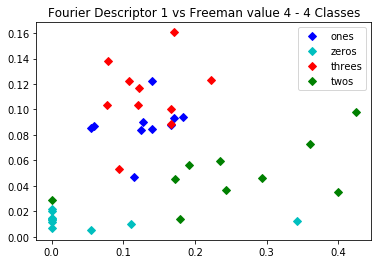

In [65]:
#Fourier descriptor 1 vs Freeman value 4 (worked in 2 vs 3 case)
z_labeled,o_labeled,t_labeled,th_labeled = False, False, False, False
for norm, fourier, label in zip(norm_counts1,fourier_sk1, labels_sk1):
    if label==0:
        plt.plot(norm[4],fourier[1],'cD',label='zeros' if not z_labeled else None)
        z_labeled=True
    elif label==1:
        plt.plot(norm[4],fourier[1],'bD',label='ones' if not o_labeled else None)
        o_labeled = True
for norm, fourier, label in zip(norm_counts2,fourier_sk2, labels_sk2):
    if label==2:
        plt.plot(norm[4],fourier[1],'gD', label='twos' if not t_labeled else None)
        t_labeled = True
    elif label==3:
        plt.plot(norm[4],fourier[1],'rD', label='threes' if not th_labeled else None)
        th_labeled = True
plt.legend()
plt.title('Fourier Descriptor 1 vs Freeman value 4 - 4 Classes')
plt.show()

Once again, it is impossible to separate all four classes using only two features. Adding additional features would add new dimensions to the graph that may produce a linear separation between the four digits. However, this is very challenging in the 2-dimensional case and would require extremely robust features or very similar digit images within each class. In general, it is difficult to differentiate between classes when there are more classes than features.